# Steam Sale Sensei

Predicting when a game will first go on sale. Dataset starts from a kaggle dataset to first get a list of games, and then pricing history data comes from https://docs.isthereanydeal.com

## Data Collection

In [39]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import requests
from dotenv import load_dotenv
from datetime import datetime

In [2]:
games_df = pd.read_csv('../data/games.csv')
games_df.head(3)

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


Just looking at some specific games to cpoy and paste exact string to test the API.

In [3]:
for game in games_df['Name']:
    if type(game) ==str and 'Batman' in game:
        print(game)

Batman™: Arkham Origins Blackgate - Deluxe Edition
Batman: Arkham City
LEGO® Batman™ 3: Beyond Gotham
Batman: The Enemy Within - The Telltale Series
Batman™: Arkham Origins
Batman™: Arkham VR
Batman™: Arkham Knight
Batman: Arkham Asylum Game of the Year Edition
Batman: Arkham Asylum Game of the Year Edition
Batman: Arkham City - Game of the Year Edition
Batman - The Telltale Series
LEGO® Batman™: The Videogame
LEGO® Batman™ 2: DC Super Heroes


In [4]:
games_df[games_df['Name'] == 'Batman™: Arkham Knight']

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
35324,208650,Batman™: Arkham Knight,"Jun 23, 2015",2000000 - 5000000,1996,17,19.99,24,Batman™: Arkham Knight brings the award-winnin...,"['English', 'French', 'Italian', 'German', 'Sp...",...,289,870,455,Rocksteady Studios,Warner Bros. Interactive Entertainment,"Single-player,Steam Achievements,Full controll...","Action,Adventure","Action,Open World,Superhero,Stealth,Adventure,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


### Exploring IsThereAnyDeal API

The API won't give us everything we need with one simple request, so we can follow these steps:
1. Use the title or AppID of a game to look it up and get the game_id
2. Using the game_id we can get the game info, which has the release date
3. Finally we also just need the pricing history to see when it first went on sale.

Target variable will (likely) be the number of months it took before the game went on sale for the first time.

In [89]:
load_dotenv('../.env')
api_key = os.getenv('API_KEY')

In [349]:
# helper function to make requests and prevent repetitive code
def request_game_data(endpoint, params):
    response = requests.get(endpoint, params=params)

    if response.status_code == 200:
        data = response.json()
        return data
    else:
        return f'Error: {response.status_code}'

Getting game id

In [350]:
endpoint = 'https://api.isthereanydeal.com/games/lookup/v1'

params = {
    'key': api_key,
    'appid': 208650
    #'title': 'Batman™: Arkham Knight'
}

game_lookup = request_game_data(endpoint, params)
print(game_lookup)


{'found': True, 'game': {'id': '018d937f-0e0c-70be-91d5-75e399e6b4e3', 'slug': 'batman-arkham-knight', 'title': 'Batman: Arkham Knight', 'type': 'game', 'mature': False}}


Getting game info for release date

In [351]:
endpoint = "https://api.isthereanydeal.com/games/info/v2"

params = {
    'key': api_key,
    'id': '018d937f-0e0c-70be-91d5-75e399e6b4e3'
}

game_info = request_game_data(endpoint, params)
print(game_info)
print(game_info['releaseDate'])

{'id': '018d937f-0e0c-70be-91d5-75e399e6b4e3', 'slug': 'batman-arkham-knight', 'title': 'Batman: Arkham Knight', 'type': 'game', 'mature': False, 'assets': {'boxart': 'https://dbxce1spal1df.cloudfront.net/018d937f-0e0c-70be-91d5-75e399e6b4e3/boxart.jpg', 'banner145': 'https://dbxce1spal1df.cloudfront.net/018d937f-0e0c-70be-91d5-75e399e6b4e3/banner145.jpg', 'banner300': 'https://dbxce1spal1df.cloudfront.net/018d937f-0e0c-70be-91d5-75e399e6b4e3/banner300.jpg', 'banner400': 'https://dbxce1spal1df.cloudfront.net/018d937f-0e0c-70be-91d5-75e399e6b4e3/banner400.jpg', 'banner600': 'https://dbxce1spal1df.cloudfront.net/018d937f-0e0c-70be-91d5-75e399e6b4e3/banner600.jpg'}, 'earlyAccess': False, 'achievements': True, 'tradingCards': True, 'appid': 208650, 'tags': ['Action', 'Open World', 'Superhero', 'Stealth', 'Third Person'], 'releaseDate': '2015-06-23', 'developers': [{'id': 423, 'name': 'Rocksteady Studios'}, {'id': 6704, 'name': 'Rocksteady'}], 'publishers': [{'id': 21, 'name': 'Warner Bros.

Getting game price history

In [352]:
endpoint_prices = 'https://api.isthereanydeal.com/games/history/v2'

since_datetime = datetime.strptime('2015-06-23 00:0:00', '%Y-%m-%d %H:%M:%S') # random release date
# since_datetime = datetime.strptime(f"{game_info['releaseDate']} 00:0:00", "%Y-%m-%d %H:%M:%S") # using release date from previous cell
since_datetime_str = since_datetime.isoformat() + '-05:00'


params = {
    'key': api_key,
    'country': 'US',
    'id': "018d937f-0e0c-70be-91d5-75e399e6b4e3",
    'shops': [61],
    'since': since_datetime_str
}

print(request_game_data(endpoint_prices, params))

[{'timestamp': '2024-05-20T19:17:02+02:00', 'shop': {'id': 61, 'name': 'Steam'}, 'deal': {'price': {'amount': 3.99, 'amountInt': 399, 'currency': 'USD'}, 'regular': {'amount': 19.99, 'amountInt': 1999, 'currency': 'USD'}, 'cut': 80}}, {'timestamp': '2024-04-18T19:15:49+02:00', 'shop': {'id': 61, 'name': 'Steam'}, 'deal': {'price': {'amount': 19.99, 'amountInt': 1999, 'currency': 'USD'}, 'regular': {'amount': 19.99, 'amountInt': 1999, 'currency': 'USD'}, 'cut': 0}}, {'timestamp': '2024-04-11T19:18:03+02:00', 'shop': {'id': 61, 'name': 'Steam'}, 'deal': {'price': {'amount': 3.99, 'amountInt': 399, 'currency': 'USD'}, 'regular': {'amount': 19.99, 'amountInt': 1999, 'currency': 'USD'}, 'cut': 80}}, {'timestamp': '2024-03-21T18:18:55+01:00', 'shop': {'id': 61, 'name': 'Steam'}, 'deal': {'price': {'amount': 19.99, 'amountInt': 1999, 'currency': 'USD'}, 'regular': {'amount': 19.99, 'amountInt': 1999, 'currency': 'USD'}, 'cut': 0}}, {'timestamp': '2024-03-14T18:27:41+01:00', 'shop': {'id': 61,

### Getting Pricing History Data

The games_df data from Kaggle has too much data to make requests for iteratively. Thus, let's look at value counts to consider how to select a subset.

In [353]:
# convert release date into proper format
def parse_date(date_string):
    # Define the possible date formats
    date_formats = ["%b %d, %Y", "%b %Y", "%Y"]
    
    for date_format in date_formats:
        try:
            return datetime.strptime(date_string, date_format).strftime("%Y-%m-%d")
        except ValueError:
            continue
    # If no format matches, return None or any default value
    return None

# Apply the function to the 'Release date' column
games_df['ReleaseDate'] = games_df['Release date'].apply(parse_date)

In [354]:
games_df['ParsedReleaseDate'] = pd.to_datetime(games_df['ReleaseDate'], format="%Y-%m-%d")

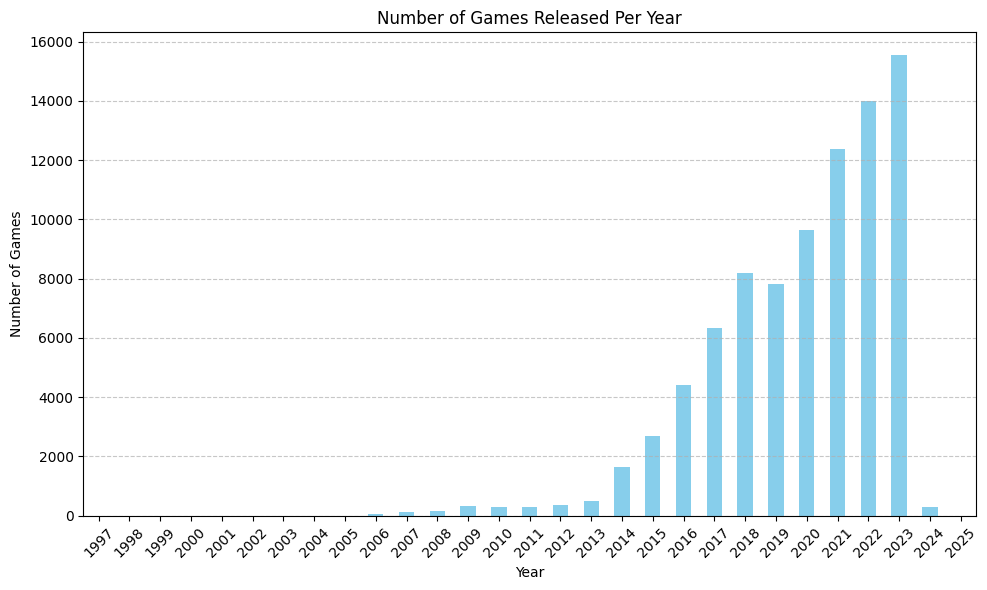

In [355]:
games_df['year'] = games_df['ParsedReleaseDate'].dt.year
year_counts = games_df['year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
year_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Games Released Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

We need data that will cover enough time to have games that will have gone on sale, and we still want a good amount. It's possible pandemic could have affect how long the first sale occured, and we don't want to make too many requests whilst still getting data from about 10000 games. Thus, let's use years 2016 and 2017 for now.

In [15]:
games_selected_years_df = games_df[games_df['year'] >= 2016]
games_selected_years_df = games_selected_years_df[games_selected_years_df['year'] < 2018]
games_selected_years_df = games_selected_years_df.reset_index(drop=True)
games_selected_years_df.shape

(10750, 42)

In [360]:
# coming back here to add 2014/2015 data too since there were a lot of nulls and model isn't performing well
games_2014_2015_df = games_df[games_df['year'] >= 2014]
games_2014_2015_df = games_2014_2015_df[games_2014_2015_df['year'] < 2016]
games_2014_2015_df = games_2014_2015_df.reset_index(drop=True)
games_2014_2015_df.shape

(4327, 42)

In [361]:
# saving this for ease of access later
#games_selected_years_df.to_csv('../data/games_2016_2017.csv')
games_2014_2015_df.to_csv('../data/games_2014_2015.csv')

We should also filter out games that don't support English.

In [362]:
import numpy as np
import ast

In [363]:
def remove_non_english_games(supported_languages_lst):
    #supported_languages_lst = ast.literal_eval(supported_languages_lst)
    if 'English' not in supported_languages_lst:
        return np.nan
    else:
        return supported_languages_lst

In [121]:
games_selected_years_df['Supported languages'] = games_selected_years_df['Supported languages'].apply(remove_non_english_games)

games_selected_years_df = games_selected_years_df.dropna(subset=['Supported languages'])
games_selected_years_df.shape

(10613, 42)

In [364]:
games_2014_2015_df['Supported languages'] = games_2014_2015_df['Supported languages'].apply(remove_non_english_games)

games_2014_2015_df = games_2014_2015_df.dropna(subset=['Supported languages'])
games_2014_2015_df.shape

(4304, 42)

The documentation doesn't specify a rate limit, so we can try to find it - in fact, it doesn't seem to have one.

In [12]:
# testing to see if requests has the rate limit
endpoint_prices = 'https://api.isthereanydeal.com/games/history/v2'

since_datetime = datetime.strptime('2015-06-23 00:0:00', '%Y-%m-%d %H:%M:%S') # random release date
since_datetime_str = since_datetime.isoformat() + '-05:00'

params = {
    'key': api_key,
    'country': 'US',
    'id': "018d937f-0e0c-70be-91d5-75e399e6b4e3",
    'shops': [61],
    'since': since_datetime_str
}

response = requests.get(endpoint, params=params)
if response.status_code == 200:
    # Print the response headers
    print("Response Headers:")
    for header, value in response.headers.items():
        print(f"{header}: {value}")
    
    rate_limit = response.headers.get('X-RateLimit-Limit')
    rate_remaining = response.headers.get('X-RateLimit-Remaining')
    rate_reset = response.headers.get('X-RateLimit-Reset')

    print("\nRate Limit Info:")
    if rate_limit:
        print(f"X-RateLimit-Limit: {rate_limit}")
    if rate_remaining:
        print(f"X-RateLimit-Remaining: {rate_remaining}")
    if rate_reset:
        print(f"X-RateLimit-Reset: {rate_reset}")

Response Headers:
Date: Sun, 19 May 2024 12:59:59 GMT
Content-Type: application/json
Transfer-Encoding: chunked
Connection: keep-alive
set-cookie: PHPSESSID=o2ihjn7q3tpm2i7f8nab2pgufa; path=/
expires: Thu, 19 Nov 1981 08:52:00 GMT
Cache-Control: no-store, no-cache, must-revalidate
pragma: no-cache
x-frame-options: DENY
access-control-allow-origin: *
CF-Cache-Status: DYNAMIC
Report-To: {"endpoints":[{"url":"https:\/\/a.nel.cloudflare.com\/report\/v4?s=PaxE%2BRGPjB0kYJ5%2FS9MzzRFoaTM%2FOAfDvI%2F6Kk2zOYHZSBUM7F%2FY6lHnj6M8sD%2B4ZiAt32Ds%2FKvobIkjzB9DU5krz%2Bys02ycsDQ12MWpw49fXc9H1iV4ouesqWJVHbzXTocPHTHvehQ%3D"}],"group":"cf-nel","max_age":604800}
NEL: {"success_fraction":0,"report_to":"cf-nel","max_age":604800}
Server: cloudflare
CF-RAY: 8864446e6f16726b-EWR
Content-Encoding: br
alt-svc: h3=":443"; ma=86400

Rate Limit Info:


No rate limit, will have to guess then.

We don't need to request the release date since we have that here from the Kaggle dataset, but note if we add future data then we will need to.

In [365]:
def get_game_id(appid, api_key, endpoint = 'https://api.isthereanydeal.com/games/lookup/v1'):
    params = {
        'key': api_key,
        'appid': appid
    }

    game_lookup = request_game_data(endpoint, params)
    
    return game_lookup['game']['id']

#with the kaggle data, we already have release dates, so this is unnecessary for now
def get_game_info(game_id, api_key, endpoint = 'https://api.isthereanydeal.com/games/info/v2'):
    params = {
        'key': api_key,
        'id': game_id
    }

    game_info = request_game_data(endpoint, params)
    
    return game_info['releaseDate']

def get_price_history(game_id, release_date, endpoint='https://api.isthereanydeal.com/games/history/v2'):
    since_datetime = datetime.strptime(f"{release_date} 00:0:00", "%Y-%m-%d %H:%M:%S")
    since_datetime_str = since_datetime.isoformat() + '-05:00'


    params = {
        'key': api_key,
        'country': 'US',
        'id': game_id,
        'shops': [61], # 61 is Steam
        'since': since_datetime_str
    }

    price_history = request_game_data(endpoint, params)

    return price_history

Iterating through games_df to get pricing history data.

In [ ]:
# If we want to limit requests, but in an old post they said there is not limit:
import time

# don't know what rate limit is so adding a typical one here of 60 requests per minute
max_requests_per_minute = 60

# each function call makes a request
requests_per_iteration = 2

# Calculate the required wait time between iterations
wait_time_per_iteration = 60 / (max_requests_per_minute / requests_per_iteration)

In [138]:
game_id_lst = []
price_history_lst = []

for i, row in games_selected_years_df.iterrows():
    try:
        game_id = get_game_id(row['AppID'], api_key)
        games_price_history = get_price_history(game_id, row['ReleaseDate'])

        game_id_lst.append(game_id)
        price_history_lst.append(games_price_history)
    except Exception as e:
        print(f"An error occurred for row {i}: {e}")
        continue

    
    # time.sleep(wait_time_per_iteration) # uncomment if want to limit requests

An error occurred for row 1840: string indices must be integers
An error occurred for row 4995: string indices must be integers
An error occurred for row 4996: string indices must be integers
An error occurred for row 4997: string indices must be integers
An error occurred for row 4999: string indices must be integers
An error occurred for row 5000: string indices must be integers
An error occurred for row 5003: string indices must be integers
An error occurred for row 5004: string indices must be integers
An error occurred for row 5007: string indices must be integers
An error occurred for row 5012: string indices must be integers
An error occurred for row 10305: 'game'


In [139]:
game_id_series = pd.Series(game_id_lst)
price_history_series = pd.Series(price_history_lst)

api_data = pd.concat([game_id_series, price_history_series], axis = 1)
api_data = api_data.rename(columns={0:'game_ids', 1:'price_history'})

In [141]:
api_data.to_csv('../data/price_history.csv')

Redoing the above for games in 2014 and 2015 since the model isn't doing well and more data could be useful.

In [367]:
# forgot to save appids here last time so adding it now

game_id_lst = []
appids = []
price_history_lst = []

for i, row in tqdm(games_2014_2015_df.iterrows(), total=games_2014_2015_df.shape[0], desc="Processing rows"):
    try:
        games_appid = row['AppID']

        game_id = get_game_id(games_appid, api_key)
        games_price_history = get_price_history(game_id, row['ReleaseDate'])

        appids.append(games_appid)
        game_id_lst.append(game_id)
        price_history_lst.append(games_price_history)
    except Exception as e:
        print(f"An error occurred for row {i}: {e}")
        continue

Processing rows:  58%|█████▊    | 2494/4304 [1:14:52<45:43,  1.52s/it]  

An error occurred for row 2503: 'game'


Processing rows: 100%|██████████| 4304/4304 [2:08:59<00:00,  1.80s/it]  


In [389]:
game_id_series_2014_2015 = pd.Series(game_id_lst)
appids_2014_2015 = pd.Series(appids)
price_history_series_2014_2015 = pd.Series(price_history_lst)

api_data_2014_2015 = pd.concat([appids_2014_2015, game_id_series_2014_2015, price_history_series_2014_2015], axis = 1)
api_data_2014_2015.columns = ['appid', 'game_ids', 'price_history']

api_data_2014_2015.to_csv('../data/price_history_2014_2015.csv', index=False)

In [384]:
print(api_data_2014_2015.shape)
api_data_2014_2015.head(3)

(4303, 3)


,appid,game_ids,price_history
0,320150,018d937f-1991-707d-9471-9514d5fe9ba7,"[{'timestamp': '2024-02-11T02:18:44+01:00', 's..."
1,346560,018d937f-33d7-726f-bf1d-b8a4482faf81,"[{'timestamp': '2024-05-20T19:16:12+02:00', 's..."
2,262150,018d937e-f545-7261-8deb-4868dcf6151e,"[{'timestamp': '2024-05-13T19:21:27+02:00', 's..."


### Merging Datasets

Now let's put these dataframes together. We need to remove the indices that had errors first though.

In [91]:
games_selected_years_df = pd.read_csv('../data/games_2016_2017.csv')
games_selected_years_df = games_selected_years_df.drop(columns='Unnamed: 0')
games_selected_years_df.shape

(10750, 42)

In [92]:
api_data = pd.read_csv('../data/price_history.csv')
api_data = api_data.drop(columns='Unnamed: 0')
api_data = api_data.drop_duplicates(subset='game_ids')
api_data.shape

(10601, 2)

So 148 rows are missing, but we don't know which ones. Unfortunately we will have to iterate again, but we can use the api_data and just look up the games and get the app_id. 

Commenting this cell out so don't accidentally run for loop (takes hours) and overwrite the games info (which will be empty if didn't load in API key).

In [ ]:
# from tqdm import tqdm

# # we'll just get the full info just in case
# def get_game_info(game_id, api_key, endpoint = 'https://api.isthereanydeal.com/games/info/v2'):
#     params = {
#         'key': api_key,
#         'id': game_id
#     }

#     game_info = request_game_data(endpoint, params)
    
#     return game_info

# game_info_lst = []

# game_ids = list(api_data['game_ids'])

# for i, game_id in enumerate(tqdm(game_ids, desc="Processing game IDs")):
#     try:
#         game_info = get_game_info(game_id, api_key)
#         game_info_lst.append(game_info)
#     except Exception as e:
#         print(f"An error occurred at index {i}: {e}")
#         continue

# game_info_df = pd.DataFrame(game_info_lst)
# game_info_df.to_csv('../data/game_info.csv', index=False)

In [97]:
game_info_df = pd.read_csv('../data/game_info.csv')

There are some null values and duplicates to get rid of.

In [98]:
game_info_df['appid'].isna().sum()

239

In [99]:
game_info_df2 = game_info_df.dropna(subset='appid')
game_info_df2 = game_info_df2.rename(columns={'id': 'game_ids'})

# because we didn't remove duplicates in api_data before, we ended up with the same duplicate here
game_info_df2 = game_info_df2.drop_duplicates(subset='game_ids')
game_info_df2.shape


(10362, 18)

In [100]:
complete_api_data = game_info_df2.merge(api_data, how='left', on='game_ids')
complete_api_data.shape

(10362, 19)

Now we can combine all three datasets to get what we need to make predictions.

In [101]:
complete_api_data = complete_api_data.rename(columns={'appid': 'AppID'})

In [102]:
complete_api_data = complete_api_data.rename(columns={'appid': 'AppID'})
complete_api_data = complete_api_data.merge(games_selected_years_df, how='left', on='AppID')

In [103]:
complete_api_data.head(3)

,game_ids,slug,title,type,mature,assets,earlyAccess,achievements,tradingCards,AppID,...,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies,ReleaseDate,ParsedReleaseDate,year
0,018d937f-0a5b-70dc-b37c-4a0a46d1b122,train-bandit,Train Bandit,game,False,{'boxart': 'https://dbxce1spal1df.cloudfront.n...,False,True,False,655370.0,...,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,2017-10-12,2017-10-12,2017.0
1,018d937f-00f3-70e3-b3ff-eeb61ac9966c,cthulhu-realms,Cthulhu Realms,game,False,{'boxart': 'https://dbxce1spal1df.cloudfront.n...,False,False,False,485000.0,...,"Wise Wizard Games, LLC","Wise Wizard Games, LLC","Single-player,Multi-player,Shared/Split Screen...",Strategy,"Card Game,Strategy,Deckbuilding,Lovecraftian,B...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,2016-07-01,2016-07-01,2016.0
2,018d937f-158f-72b0-9909-e63af7a0fbbe,steam-squad,Steam Squad,game,False,{'boxart': 'https://dbxce1spal1df.cloudfront.n...,False,True,True,290870.0,...,Bretwalda Games,Bretwalda Games,"Single-player,Multi-player,PvP,Shared/Split Sc...","Indie,Strategy","Strategy,Indie,Turn-Based,World War I,Steampun...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,2016-07-28,2016-07-28,2016.0


Now let's take a closer look at all the columns to see which ones might be of interest for modeling.

In [104]:
example_row = dict(complete_api_data.iloc[0, :])

for key, value in example_row.items():
    print(key)
    print(value, '\n')

game_ids
018d937f-0a5b-70dc-b37c-4a0a46d1b122 

slug
train-bandit 

title
Train Bandit 

type
game 

mature
False 

assets
{'boxart': 'https://dbxce1spal1df.cloudfront.net/018d937f-0a5b-70dc-b37c-4a0a46d1b122/boxart.jpg', 'banner145': 'https://dbxce1spal1df.cloudfront.net/018d937f-0a5b-70dc-b37c-4a0a46d1b122/banner145.jpg', 'banner300': 'https://dbxce1spal1df.cloudfront.net/018d937f-0a5b-70dc-b37c-4a0a46d1b122/banner300.jpg', 'banner400': 'https://dbxce1spal1df.cloudfront.net/018d937f-0a5b-70dc-b37c-4a0a46d1b122/banner400.jpg', 'banner600': 'https://dbxce1spal1df.cloudfront.net/018d937f-0a5b-70dc-b37c-4a0a46d1b122/banner600.jpg'} 

earlyAccess
False 

achievements
True 

tradingCards
False 

AppID
655370.0 

tags
['Indie', 'Action', 'Pixel Graphics', '2D', 'Retro'] 

releaseDate
2017-10-12 

developers
[{'id': 7238, 'name': 'Rusty Moyher'}] 

publishers
[{'id': 12181, 'name': 'Wild Rooster'}] 

reviews
[{'score': 86, 'source': 'Steam', 'count': 58, 'url': 'https://store.steampowered.co

Here are the potentially useful columns for modeling. Note, we are selecting columns with info that we would have for a new game. Data like player count or reviews aren't useful for predicting newer games (unless we had that data for a game on initial release, but we don't). 

- mature
- tradingCards
- achievements
- earlyAccess
- tags or Tags (duplicate columns)
- publishers
- price_history
- Release date or ReleaseDate (already in datetime friendly format)
- About the game
- Supported Languages
- Windows
- Mac
- Linux
- Categories
- Genres

We will want the game_id, appid, and title as well just in case.

In [408]:
raw_train_test_data = complete_api_data[['game_ids', 'AppID', 'title', 'mature', 'earlyAccess',
       'achievements', 'tradingCards', 'price_history', 'About the game',
       'Supported languages', 'Windows',
       'Mac', 'Linux', 'Publishers', 'Categories', 'Genres', 'Tags',
       'ReleaseDate']]

print(raw_train_test_data.shape)
raw_train_test_data.head(3)

(10362, 18)


,game_ids,AppID,title,mature,earlyAccess,achievements,tradingCards,price_history,About the game,Supported languages,Windows,Mac,Linux,Publishers,Categories,Genres,Tags,ReleaseDate
0,018d937f-0a5b-70dc-b37c-4a0a46d1b122,655370.0,Train Bandit,False,False,True,False,"[{'timestamp': '2024-05-13T19:16:33+02:00', 's...",THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,False,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",2017-10-12
1,018d937f-00f3-70e3-b3ff-eeb61ac9966c,485000.0,Cthulhu Realms,False,False,False,False,"[{'timestamp': '2024-02-11T03:20:08+01:00', 's...",Star Realms has gone insane! Introducing Cthul...,['English'],True,True,False,"Wise Wizard Games, LLC","Single-player,Multi-player,Shared/Split Screen...",Strategy,"Card Game,Strategy,Deckbuilding,Lovecraftian,B...",2016-07-01
2,018d937f-158f-72b0-9909-e63af7a0fbbe,290870.0,Steam Squad,False,False,True,True,"[{'timestamp': '2024-02-11T02:17:53+01:00', 's...","Steam Squad - tactical wargame, where gameplay...","['English', 'Russian', 'French', 'German']",True,True,True,Bretwalda Games,"Single-player,Multi-player,PvP,Shared/Split Sc...","Indie,Strategy","Strategy,Indie,Turn-Based,World War I,Steampun...",2016-07-28


In [393]:
games_2014_2015_df = pd.read_csv('../data/games_2014_2015.csv')
games_2014_2015_df = games_2014_2015_df.drop(columns='Unnamed: 0')
games_2014_2015_df.shape

(4327, 42)

In [396]:
# doing this again for 2014-2015 data

api_data_2014_2015 = pd.read_csv('../data/price_history_2014_2015.csv')
api_data_2014_2015 = api_data_2014_2015.rename(columns = {'appid': 'AppID'})

complete_api_data_2014_2015 = api_data_2014_2015.merge(games_2014_2015_df, how='left', on='AppID')
complete_api_data_2014_2015.head(3)

,AppID,game_ids,price_history,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,...,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies,ReleaseDate,ParsedReleaseDate,year
0,320150,018d937f-1991-707d-9471-9514d5fe9ba7,"[{'timestamp': '2024-02-11T02:18:44+01:00', 's...",Deadlings: Rotten Edition,"Nov 11, 2014",50000 - 100000,0,0,3.99,0,...,ONE MORE LEVEL,ONE MORE LEVEL,"Single-player,Steam Achievements,Steam Trading...","Action,Adventure,Indie","Action,Indie,Adventure,Puzzle-Platformer,Arcad...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,2014-11-11,2014-11-11,2014
1,346560,018d937f-33d7-726f-bf1d-b8a4482faf81,"[{'timestamp': '2024-05-20T19:16:12+02:00', 's...",Hero of the Kingdom II,"Feb 20, 2015",100000 - 200000,5,0,7.99,0,...,Lonely Troops,Lonely Troops,"Single-player,Steam Achievements,Steam Trading...","Adventure,Casual,Indie,RPG","Adventure,Casual,Point & Click,RPG,Indie,Isome...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,2015-02-20,2015-02-20,2015
2,262150,018d937e-f545-7261-8deb-4868dcf6151e,"[{'timestamp': '2024-05-13T19:21:27+02:00', 's...",Vanguard Princess,"Mar 3, 2014",200000 - 500000,1,0,2.49,7,...,Tomoaki Sugeno,eigoMANGA,"Single-player,Multi-player,PvP,Shared/Split Sc...","Action,Casual,Indie","Anime,Fighting,2D Fighter,Indie,Female Protago...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,2014-03-03,2014-03-03,2014


In [398]:
complete_api_data_2014_2015.columns

Index(['AppID', 'game_ids', 'price_history', 'Name', 'Release date',
       'Estimated owners', 'Peak CCU', 'Required age', 'Price', 'DLC count',
       'About the game', 'Supported languages', 'Full audio languages',
       'Reviews', 'Header image', 'Website', 'Support url', 'Support email',
       'Windows', 'Mac', 'Linux', 'Metacritic score', 'Metacritic url',
       'User score', 'Positive', 'Negative', 'Score rank', 'Achievements',
       'Recommendations', 'Notes', 'Average playtime forever',
       'Average playtime two weeks', 'Median playtime forever',
       'Median playtime two weeks', 'Developers', 'Publishers', 'Categories',
       'Genres', 'Tags', 'Screenshots', 'Movies', 'ReleaseDate',
       'ParsedReleaseDate', 'year'],
      dtype='object')

So we don't have `title` but we have `name` - `title` comes from the game_info api which we didn't use here but we don't need it for modeling anyway. The other columns we can't get are `mature`, `earlyAccess`, and `tradingCards` but we can remove these (tradinCards shows up in the Tags column anyway, earlyAccess isn't relevant to us here, and finally mature has too few True values as you'll see below).

In [403]:
raw_train_test_data_2 = complete_api_data_2014_2015[
    ['game_ids', 'AppID', 'Name', 'Achievements', 'price_history', 'About the game', 'Supported languages', 
    'Windows', 'Mac', 'Linux', 'Publishers', 'Categories', 'Genres', 'Tags', 'ReleaseDate']]

    

## EDA and Preprocessing

### Target Variable

The target variable will be the amount of time from the release date to the first price drop. We will consider the time in months. First let's clean the raw_train_test_data dataframe.

In [451]:
import ast
import numpy as np
from collections import Counter

In [452]:
def safe_eval(val, eval_func):
    if pd.isna(val):  # Check for NaN values
        return val
    if isinstance(val, str):  # Ensure the value is a string
        try:
            return eval_func(val)
        except (ValueError, SyntaxError):
            return val  # Return the original value if it can't be parsed
    return val  # Return the original value if it's not a string

def preprocess_price_history(df):
    # convert string lists to lists remove empty lists
    df['price_history'] = df['price_history'].apply(lambda x: safe_eval(x, ast.literal_eval))

    # remove empty lists
    df = df[df['price_history'].apply(lambda x: len(x) > 0)]
    df = df.reset_index(drop=True)

    return df

def preprocess_release_date(df):
    df = df.dropna(subset='ReleaseDate')
    df = df.reset_index(drop=True)
    return df

def time_until_discount(price_history, release_date):
    for i in range(len(price_history)-1, -1, -1):
        ph = price_history[i]

        # need to make sure we only consider steam sales and the discount date isn't before release date
        shop_id = ph['shop']['id']
        discount_date = ph['timestamp']
        discount_date = datetime.fromisoformat(discount_date).date()

        if (shop_id == 61) and (release_date < discount_date):
            regular_price = ph['deal']['regular']['amount']
            discount_price = ph['deal']['price']['amount']

            if discount_price < regular_price:
                time_delta = discount_date - release_date
                months_until_discount = time_delta.days

                return months_until_discount
        else:
            continue
        
    # if never went on sale, then return the the time since release in months
    final_recorded_date = datetime.fromisoformat(price_history[0]['timestamp']).date()
    time_since_release = (final_recorded_date - release_date).days
    return time_since_release


def remove_price_history_errors(df):
    days_until_discount_lst = []

    for i, row in df.iterrows():
        #print(i)
        release_date = datetime.fromisoformat(row['ReleaseDate']).date()
        try:
            time_delta = time_until_discount(row['price_history'], release_date)
            if time_delta < 0:
                days_until_discount_lst.append(0)
            else:
                days_until_discount_lst.append(time_delta)
        except (TypeError):
            days_until_discount_lst.append(np.nan)
            continue

    return pd.DataFrame(days_until_discount_lst)

def get_time_delta_col(df):
    days_until_sale = remove_price_history_errors(df)
    df = pd.concat([df, days_until_sale], axis=1)
    df = df.rename(columns={0:'TimeDelta'})
    df = df.dropna(subset='TimeDelta')
    df = df.reset_index(drop=True)
    return df

# might only want to not consider games that went on sale on release or never since release
def when_did_it_discount(price_history, release_date):
    for i in range(len(price_history)-1, -1, -1):
        ph = price_history[i]

        # need to make sure we only consider steam sales and the discount date isn't before release date
        shop_id = ph['shop']['id']
        discount_date = ph['timestamp']
        discount_date = datetime.fromisoformat(discount_date).date()

        if (shop_id == 61) and (release_date < discount_date):
            regular_price = ph['deal']['regular']['amount']
            discount_price = ph['deal']['price']['amount']

            if discount_price < regular_price:
                if i == 0:
                    return 'went on sale on release'
                else:
                    return 'went on sale'
        else:
            continue

    return 'never went on sale'

def get_sales_type(df):
    sale_types = []

    for i, row in df.iterrows():
        #print(i)
        release_date = datetime.fromisoformat(row['ReleaseDate']).date()
        try:
            sale_type = when_did_it_discount(row['price_history'], release_date)
            sale_types.append(sale_type)
        except (TypeError):
            print(i)
            sale_types.append('error')
            continue

    sale_type_df = pd.DataFrame(sale_types)
    sale_type_df = sale_type_df.rename(columns={0: 'SaleType'})

    return sale_type_df

In [ ]:
# raw_train_test_data = raw_train_test_data.dropna(subset='ReleaseDate')

# raw_train_test_data['price_history'] = raw_train_test_data['price_history'].apply(lambda x: safe_eval(x, ast.literal_eval))

# raw_train_test_data = raw_train_test_data[raw_train_test_data['price_history'].apply(lambda x: len(x) > 0)]
# raw_train_test_data = raw_train_test_data.reset_index(drop=True)

In [108]:
example_ph = raw_train_test_data['price_history'][0]
example_ph[0]

{'timestamp': '2024-05-13T19:16:33+02:00',
 'shop': {'id': 61, 'name': 'Steam'},
 'deal': {'price': {'amount': 0.49, 'amountInt': 49, 'currency': 'USD'},
  'regular': {'amount': 0.99, 'amountInt': 99, 'currency': 'USD'},
  'cut': 51}}

We have a dictionary of dictionaries to parse through.

In [109]:
example_idx = 2
regular_price = example_ph[example_idx]['deal']['regular']['amount']
print('regular price:', regular_price)

discount_price = example_ph[example_idx]['deal']['price']['amount']
print('discount price:', discount_price)

release_date = datetime.fromisoformat(raw_train_test_data['ReleaseDate'][0]).date()
print('release date:', release_date)

regular price: 0.99
discount price: 0.49
release date: 2017-10-12


In [111]:
time_until_discount(example_ph, release_date)

32

In [112]:
for i, row in raw_train_test_data.iterrows():
    #print(i)
    release_date = datetime.fromisoformat(row['ReleaseDate']).date()
    try:
        time_delta = time_until_discount(row['price_history'], release_date)
        if time_delta < 0:
            print('less than zero', i, time_delta)
    except (TypeError):
        print(i)
        continue

less than zero 3556 -7
4811
4814
4815
4820


So for whatever reason we have a few errors and negative values. Let's remove these errors and make negative values 0, indicating a discoutn price on release.

In [406]:
days_until_sale = remove_price_history_errors(raw_train_test_data)
print(days_until_sale.isna().sum())
days_until_sale.shape

0    0
dtype: int64


(10341, 1)

In [115]:
# raw_train_test_data = pd.concat([raw_train_test_data, days_until_sale], axis=1)
# raw_train_test_data = raw_train_test_data.rename(columns={0:'TimeDelta'})
# raw_train_test_data = raw_train_test_data.dropna(subset='TimeDelta')
# raw_train_test_data = raw_train_test_data.reset_index(drop=True)

In [ ]:
raw_train_test_data = preprocess_price_history(raw_train_test_data)
raw_train_test_data = preprocess_release_date(raw_train_test_data)
raw_train_test_data = get_time_delta_col(raw_train_test_data)

In [418]:
raw_train_test_data.head(3)

,game_ids,AppID,title,mature,earlyAccess,achievements,tradingCards,price_history,About the game,Supported languages,Windows,Mac,Linux,Publishers,Categories,Genres,Tags,ReleaseDate,TimeDelta
0,018d937f-0a5b-70dc-b37c-4a0a46d1b122,655370.0,Train Bandit,False,False,True,False,"[{'timestamp': '2024-05-13T19:16:33+02:00', 's...",THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,False,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",2017-10-12,32.0
1,018d937f-00f3-70e3-b3ff-eeb61ac9966c,485000.0,Cthulhu Realms,False,False,False,False,"[{'timestamp': '2024-02-11T03:20:08+01:00', 's...",Star Realms has gone insane! Introducing Cthul...,['English'],True,True,False,"Wise Wizard Games, LLC","Single-player,Multi-player,Shared/Split Screen...",Strategy,"Card Game,Strategy,Deckbuilding,Lovecraftian,B...",2016-07-01,2781.0
2,018d937f-158f-72b0-9909-e63af7a0fbbe,290870.0,Steam Squad,False,False,True,True,"[{'timestamp': '2024-02-11T02:17:53+01:00', 's...","Steam Squad - tactical wargame, where gameplay...","['English', 'Russian', 'French', 'German']",True,True,True,Bretwalda Games,"Single-player,Multi-player,PvP,Shared/Split Sc...","Indie,Strategy","Strategy,Indie,Turn-Based,World War I,Steampun...",2016-07-28,81.0


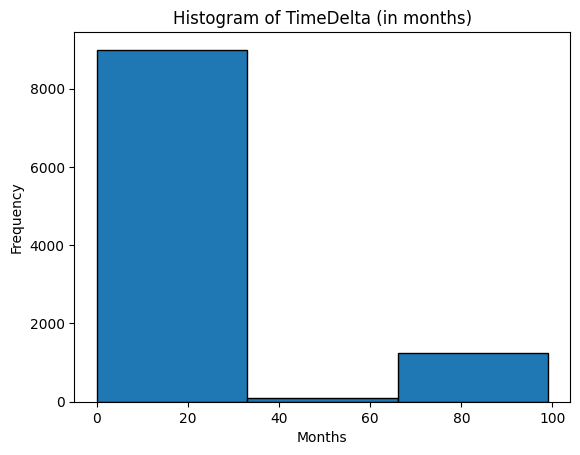

In [420]:
#time_delta_col = raw_train_test_data['TimeDelta'].apply(lambda x: int(x))
time_delta_col = raw_train_test_data['TimeDelta'].apply(lambda x: x // 30)

plt.hist(time_delta_col, bins=3, edgecolor='black')
plt.xlabel('Months')
plt.ylabel('Frequency')
plt.title('Histogram of TimeDelta (in months)')
plt.show()

In [119]:
when_did_it_discount(example_ph, release_date)

'went on sale'

In [449]:
sale_type_df = get_sales_type(raw_train_test_data)
Counter(sale_type_df['SaleType'].tolist())

Counter({'went on sale': 9009,
         'never went on sale': 1331,
         'went on sale on release': 1})

In [ ]:
raw_train_test_data = pd.concat([raw_train_test_data, sale_type_df], axis=1)

#### Games that Went on Sale

Okay so we have most of the data still if we only consider games that went on sale. We could build another model to see if a game will even go on sale though. In any case, let's focus on games that went on sale.

In [44]:
discounted_games = raw_train_test_data[raw_train_test_data['SaleType'] == 'went on sale']
discounted_games.shape

NameError: name 'raw_train_test_data' is not defined

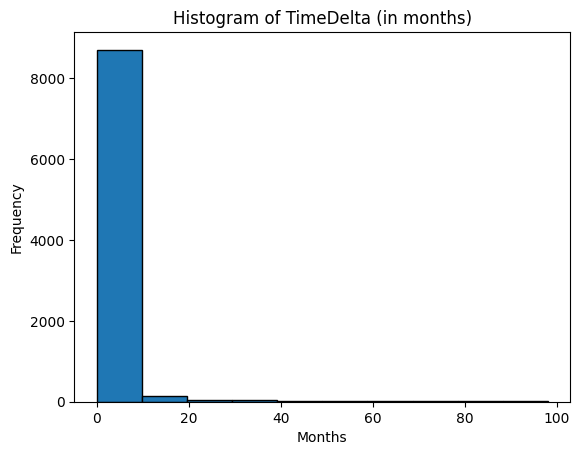

In [125]:
time_delta_discounted_games = discounted_games['TimeDelta'].apply(lambda x: x // 30)

plt.hist(time_delta_discounted_games, bins=10, edgecolor='black')
plt.xlabel('Months')
plt.ylabel('Frequency')
plt.title('Histogram of TimeDelta (in months)')
plt.show()

Looks like 40 months might be a good cutoff for games but let's explore.

number of discounted games within cutoff: 8749
number of discounted games outside of cutoff: 260


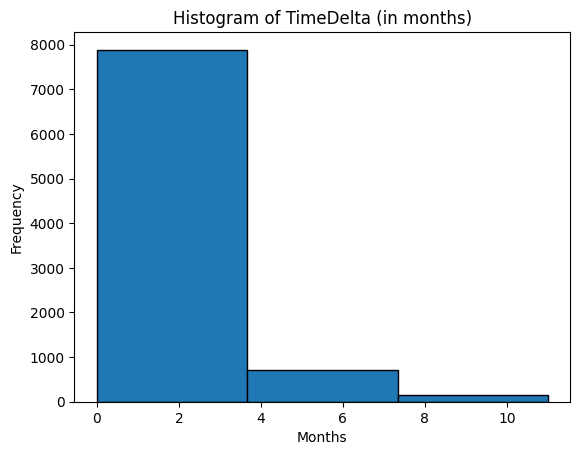

In [126]:
num_of_months_cutoff = 12

discounted_games_subset = discounted_games[discounted_games['TimeDelta'] < num_of_months_cutoff*30]
print('number of discounted games within cutoff:', discounted_games_subset.shape[0])
print('number of discounted games outside of cutoff:', discounted_games.shape[0] - discounted_games_subset.shape[0])

time_delta_discounted_games = discounted_games_subset['TimeDelta'].apply(lambda x: x // 30)

plt.hist(time_delta_discounted_games, bins=3, edgecolor='black')
plt.xlabel('Months')
plt.ylabel('Frequency')
plt.title('Histogram of TimeDelta (in months)')
plt.show()

Let's actually try an uneven bin range, meaning let's customize it to something like 0-3 months, 4-6 months, 6-12, and then more than a year.

In [127]:
months_time_delta = discounted_games['TimeDelta'] // 30
Counter(months_time_delta)

Counter({0.0: 4399,
         1.0: 1591,
         2.0: 1310,
         3.0: 585,
         4.0: 329,
         5.0: 169,
         6.0: 139,
         8.0: 69,
         7.0: 69,
         9.0: 40,
         10.0: 26,
         11.0: 23,
         12.0: 17,
         14.0: 15,
         13.0: 15,
         17.0: 13,
         16.0: 13,
         18.0: 12,
         23.0: 10,
         15.0: 8,
         30.0: 7,
         76.0: 7,
         19.0: 6,
         22.0: 6,
         21.0: 6,
         20.0: 6,
         25.0: 5,
         39.0: 5,
         83.0: 5,
         34.0: 4,
         81.0: 4,
         35.0: 4,
         37.0: 4,
         45.0: 4,
         38.0: 4,
         33.0: 3,
         48.0: 3,
         49.0: 3,
         52.0: 3,
         32.0: 3,
         77.0: 3,
         26.0: 3,
         53.0: 2,
         64.0: 2,
         62.0: 2,
         90.0: 2,
         24.0: 2,
         31.0: 2,
         27.0: 2,
         78.0: 2,
         95.0: 2,
         28.0: 2,
         51.0: 2,
         63.0: 2,
         

Based on the distribution it makes more sense to have classes based on the below chart, which is games that went on sale in less than a month, 1-3 months, 4-6 months, and then 6+ months as the final class.

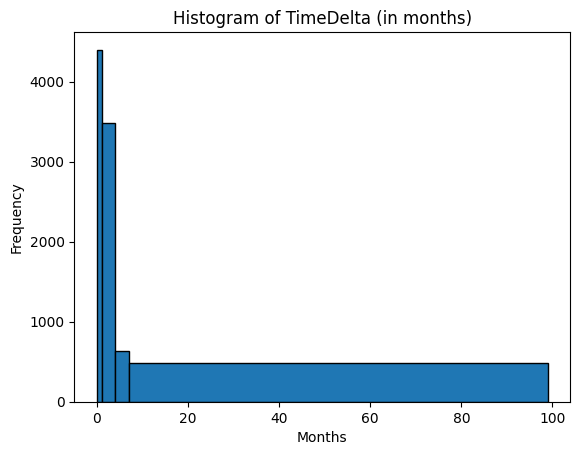

In [128]:
# disregard games that went on sale in the first month
discounted_games_subset = discounted_games[discounted_games['TimeDelta'] > 0]

#time_delta_discounted_games = months_time_delta[months_time_delta > 0] # to see data with no games that went on sale in less than a month
time_delta_discounted_games = discounted_games_subset['TimeDelta'].apply(lambda x: x // 30)

plt.hist(time_delta_discounted_games, bins = [0, 1, 4, 7, time_delta_discounted_games.max() + 1], edgecolor='black')
plt.xlabel('Months')
plt.ylabel('Frequency')
plt.title('Histogram of TimeDelta (in months)')
plt.show()

Now let's create our target variable. We want to divide it by 30 to get it in months, then if it is in our ranges we will create a new column with the respective classes.

In [129]:
months_until_sale = discounted_games['TimeDelta'] // 30
months_until_sale = months_until_sale.apply(lambda x: int(x))

bins = [-1, 0, 3, 6, float('inf')]
labels = ['less than a month', '1-3 months', '4-6 months', 'more than 6 months']
months_until_sale = pd.cut(months_until_sale, bins=bins, labels=labels)
months_until_sale

0               1-3 months
2               1-3 months
3        less than a month
4        less than a month
5        less than a month
               ...        
10334    less than a month
10335    less than a month
10336           1-3 months
10337    less than a month
10338           1-3 months
Name: TimeDelta, Length: 9009, dtype: category
Categories (4, object): ['less than a month' < '1-3 months' < '4-6 months' < 'more than 6 months']

In [130]:
discounted_games['monthsUntilSale'] = months_until_sale

C:\Users\RaviB\AppData\Local\Temp\ipykernel_17948\3379270169.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discounted_games['monthsUntilSale'] = months_until_sale


#### Adding 2014/2015 Data

In [454]:
raw_train_test_data_2 = preprocess_price_history(raw_train_test_data_2)
raw_train_test_data_2 = preprocess_release_date(raw_train_test_data_2)
raw_train_test_data_2 = get_time_delta_col(raw_train_test_data_2)
sale_type_df_2 = get_sales_type(raw_train_test_data_2)
raw_train_test_data_2 = pd.concat([raw_train_test_data_2, sale_type_df_2], axis=1)

C:\Users\RaviB\AppData\Local\Temp\ipykernel_17948\2785719401.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_history'] = df['price_history'].apply(lambda x: safe_eval(x, ast.literal_eval))


Now Let's concatenate these two dataframes together and save it for modeling. We need to remove and edit some column names first though.

In [461]:
raw_train_test_data_1 = raw_train_test_data.drop(columns=['mature', 'earlyAccess', 'tradingCards'])
raw_train_test_data_1 = raw_train_test_data_1.rename(columns={'title': 'Name', 'achievements': 'Achievements'})

In [463]:
raw_train_test_data_2.shape

(4302, 17)

In [464]:
raw_train_test_data_complete = pd.concat([raw_train_test_data_1, raw_train_test_data_2], axis=0)
raw_train_test_data_complete.shape

(14643, 17)

In [465]:
raw_train_test_data_complete.to_csv('../data/raw_data_2014-2017.csv')

Now let's filter for games that went on sale and look at the target again.

In [45]:
raw_train_test_data_complete = pd.read_csv('../data/raw_data_2014-2017.csv')
raw_train_test_data_complete = raw_train_test_data_complete.drop(columns='Unnamed: 0')

In [ ]:
Counter(raw_train_test_data_complete['SaleType'])

In [48]:
raw_train_test_data_complete[raw_train_test_data_complete['SaleType'] == 'went on sale on release']['TimeDelta']

4574    2721.0
Name: TimeDelta, dtype: float64

Time delta should be zero here, but regardless this is basically a binary column, either a game went on sale or it never did.

#### Restructuring Target Variable

In [49]:
discounted_games = raw_train_test_data_complete[raw_train_test_data_complete['SaleType'] == 'went on sale']
discounted_games.shape

(13003, 17)

In [11]:
discounted_games['TimeDelta'] = discounted_games['TimeDelta'].astype(int)

C:\Users\RaviB\AppData\Local\Temp\ipykernel_2816\1852085743.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discounted_games['TimeDelta'] = discounted_games['TimeDelta'].astype(int)


Games that went on sale on release actually have a TimeDelta value of 1 from below (there are no TimeDelta values of 0).

In [12]:
print(discounted_games[discounted_games['TimeDelta'] == 1].shape)
print(discounted_games[discounted_games['TimeDelta'] == 0].shape)

(4055, 17)
(0, 17)


(13003,)


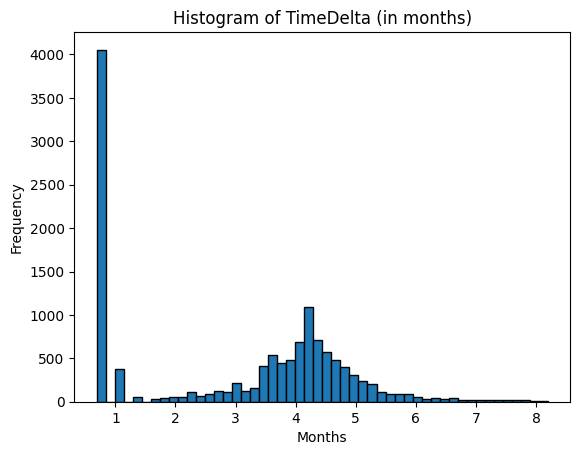

In [17]:
# taking log transform of target to see what it's like
time_delta_discounted_games = np.log1p(discounted_games['TimeDelta'])
print(time_delta_discounted_games.shape)

plt.hist(time_delta_discounted_games, bins = 50, edgecolor='black')
plt.xlabel('Months')
plt.ylabel('Frequency')
plt.title('Histogram of TimeDelta (in months)')
plt.show()

So the best thing to do here is to build a classifier model to predict if it belongs to the first peak or the normal distribution. Let's investigate the second smaller peak though.

(8569,)


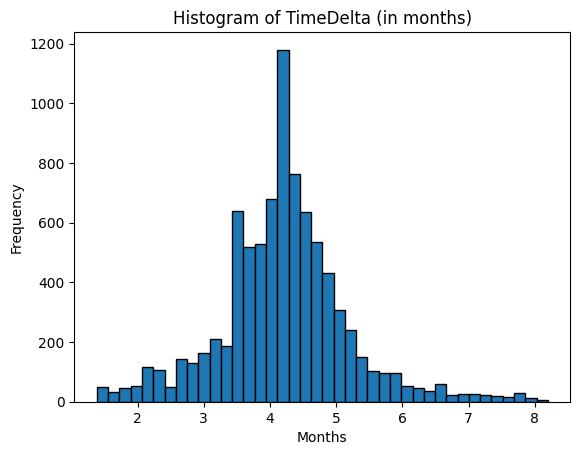

In [18]:
discounted_games_subset = discounted_games[discounted_games['TimeDelta'] > 2]
#discounted_games_subset = discounted_games_subset[discounted_games_subset['TimeDelta'] < 30*12]

# taking log transform of target to see what it's like
time_delta_discounted_games = np.log1p(discounted_games_subset['TimeDelta'])
print(time_delta_discounted_games.shape)

#time_delta_discounted_games = months_time_delta[months_time_delta > 0] # to see data with no games that went on sale in less than a month
#time_delta_discounted_games = discounted_games_subset['TimeDelta'].apply(lambda x: x // 30)

plt.hist(time_delta_discounted_games, bins = 40, edgecolor='black')
plt.xlabel('Months')
plt.ylabel('Frequency')
plt.title('Histogram of TimeDelta (in months)')
plt.show()

In [19]:
for i in range(1, 6):
    print(np.expm1(i))

1.718281828459045
6.38905609893065
19.085536923187668
53.598150033144236
147.4131591025766


In [20]:
for i in range(0, 10):
    print(f"Frequency count for games that went on sale in {i} days:", discounted_games[discounted_games['TimeDelta'] == i].shape[0])

Frequency count for games that went on sale in 0 days: 0
Frequency count for games that went on sale in 1 days: 4055
Frequency count for games that went on sale in 2 days: 379
Frequency count for games that went on sale in 3 days: 50
Frequency count for games that went on sale in 4 days: 32
Frequency count for games that went on sale in 5 days: 45
Frequency count for games that went on sale in 6 days: 52
Frequency count for games that went on sale in 7 days: 58
Frequency count for games that went on sale in 8 days: 57
Frequency count for games that went on sale in 9 days: 59


Looks like games that went on sale in the second day are also a significant separation from the normal distribution.

#### Constructing Target Variables

Let's create our targets now. There will be two.

In [52]:
discounted_games = raw_train_test_data_complete[raw_train_test_data_complete['SaleType'] == 'went on sale']
discounted_games = discounted_games.drop(columns='SaleType')

In [53]:
discounted_games['DiscountedEarly'] = discounted_games['TimeDelta'].apply(lambda x: 'discounted within 2 days' if x < 3 else 'discounted after 3 days')

In [54]:
def get_early_discount_target(df):
    # filter for games that actually did go on sale at some point
    discounted_games = df[raw_train_test_data_complete['SaleType'] == 'went on sale']
    # then we don't need that column anymore
    discounted_games = discounted_games.drop(columns='SaleType')
    # now create a new column for binary classification, it a game went on sale in the first 2 days or not
    discounted_games['DiscountedEarly'] = discounted_games['TimeDelta'].apply(lambda x: 'discounted within 2 days' if x < 3 else 'discounted after 3 days')
    return discounted_games

discounted_games = get_early_discount_target(raw_train_test_data_complete)

For the regression target variable, it will be the TimeDelta column after filtering for games that were discounted after 3 days. Then, we will take the log of the values and do a regression task.

### Steam API for User Requests

We want to make sure we can get unseen data before using it for the model. We can use this library to do this easily:

https://pypi.org/project/python-steam-api/.

Note the steam api does have a rate limit: "You are limited to one hundred thousand (100,000) calls to the Steam Web API per day." (Also saw another rate limit of around 2 seconds before each request, but not sure if this is true).

Ultimately, this will be implemented in a Streamlit app.

In [233]:
from steam_web_api import Steam

load_dotenv('../.env')
steam_api_key = os.getenv('STEAM_API_KEY')
steam = Steam(steam_api_key)

We can search games given a name, and then get thd appid from there.

In [235]:
search_games_lst = steam.apps.search_games("batman")
search_games_lst

{'apps': [{'id': [208650],
   'link': 'https://store.steampowered.com/app/208650/Batman_Arkham_Knight/?snr=1_7_15__13',
   'name': 'Batman\\u2122: Arkham Knight',
   'img': 'https://shared.akamai.steamstatic.com/store_item_assets/steam/apps/208650/capsule_sm_120.jpg?t=1702934528',
   'price': '$3.99'},
  {'id': [209000],
   'link': 'https://store.steampowered.com/app/209000/Batman_Arkham_Origins/?snr=1_7_15__13',
   'name': 'Batman\\u2122: Arkham Origins',
   'img': 'https://shared.akamai.steamstatic.com/store_item_assets/steam/apps/209000/capsule_sm_120.jpg?t=1681234740',
   'price': '$3.99'},
  {'id': [35140, 200260, 208650, 367480],
   'link': 'https://store.steampowered.com/sub/320795/?snr=1_7_15__13',
   'name': 'Batman: Arkham Collection',
   'img': 'https://shared.akamai.steamstatic.com/store_item_assets/steam/subs/320795/capsule_sm_120.jpg?t=1636658684',
   'price': '$8.99'},
  {'id': [313690],
   'link': 'https://store.steampowered.com/app/313690/LEGO_Batman_3_Beyond_Gotham/?s

So given an appid we can get the games info.

In [239]:
batman_arkham_knight = 35140
user = steam.apps.get_app_details(batman_arkham_knight)
user

{'35140': {'success': True,
  'data': {'type': 'game',
   'name': 'Batman: Arkham Asylum Game of the Year Edition',
   'steam_appid': 35140,
   'required_age': 0,
   'is_free': False,
   'detailed_description': 'Critically acclaimed Batman: Arkham Asylum returns with a remastered Game of the Year Edition, featuring 4 extra Challenge Maps. The additional Challenge Maps are Crime Alley; Scarecrow Nightmare; Totally Insane and Nocturnal Hunter (both from the Insane Night Map Pack).<br>\t\t\t\t\t<ul class="bb_ul"><li>Utilize the unique FreeFlow™ combat system to chain together unlimited combos seamlessly and battle with huge groups of The Joker’s henchmen in brutal melee brawls <br>\t\t\t\t\t</li><li>Investigate as Batman, the WORLD’S GREATEST DETECTIVE, by solving intricate puzzles with the help of cutting edge forensic tools including x-ray scanning, fingerprint scans, ‘Amido Black’ spray and a pheromone tracker<br>\t\t\t\t\t</li><li>Face off against Gotham’s greatest villains including 

And then further info can be acquired from the isthereanydeals api. This will give us what we need for end user requests.

### Independent Variables

In [131]:
X = discounted_games[['mature', 'earlyAccess', 'achievements', 'tradingCards', 'About the game', 'Supported languages', 
                      'Windows', 'Mac', 'Linux', 'Publishers', 'Categories', 'Genres', 'Tags']]

X.head(3)

,mature,earlyAccess,achievements,tradingCards,About the game,Supported languages,Windows,Mac,Linux,Publishers,Categories,Genres,Tags
0,False,False,True,False,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,False,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,False,False,True,True,"Steam Squad - tactical wargame, where gameplay...","['English', 'Russian', 'French', 'German']",True,True,True,Bretwalda Games,"Single-player,Multi-player,PvP,Shared/Split Sc...","Indie,Strategy","Strategy,Indie,Turn-Based,World War I,Steampun..."
3,False,False,False,True,Meet the continuation of the hardcore platform...,['English'],True,False,False,Volens Nolens Games,"Single-player,Steam Trading Cards","Action,Adventure,Casual,Indie","Action,Adventure,Casual,Indie,Platformer,2D Pl..."


We want to keep this simple for now, so let's trim some of these columns based on intuition. Firstly, earlyAccess isn't too relevant since we aren't considering games that were on sale before the release date. achievements probably don't contribute to player satisfaction a significant amount. Let's count total True's for all the binary columns.

In [132]:
print('Number of rows X:', X.shape[0], '\n')

for col_name in ['mature', 'earlyAccess', 'achievements', 'tradingCards', 'Windows', 'Mac', 'Linux']:
    print(f"Number of True values for the {col_name} column:", X[f"{col_name}"].sum())

print('\n', 'Number of different publishers:', len(Counter(X['Publishers'])))

Number of rows X: 9009 

Number of True values for the mature column: 33
Number of True values for the earlyAccess column: 718
Number of True values for the achievements column: 5025
Number of True values for the tradingCards column: 3632
Number of True values for the Windows column: 9000
Number of True values for the Mac column: 2823
Number of True values for the Linux column: 1961

 Number of different publishers: 5686


Some observations: the `Windows` column is basically a constant value so can be ignored. Same for the mature column. `earlyAccess` isn't as bad but almost a tenth of it is True so probably should just ignore it (already agreed it should be intuitively too). This `achievements`, `tradingCards`, `Mac`, and `Linux` are the only binary columns worth keeping.

From the dataframe above, it seems like the `Genres` columns is a subset of the Tags column, so we can drop that too. Also, the `Publishers` column has too many different ones to be meaningful (random names basically). Our new X is now:

In [133]:
X = discounted_games[['achievements', 'tradingCards', 'About the game', 'Supported languages', 
                      'Mac', 'Linux', 'Categories', 'Tags']]

X.head(2)

,achievements,tradingCards,About the game,Supported languages,Mac,Linux,Categories,Tags
0,True,False,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",True,False,"Single-player,Steam Achievements,Full controll...","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,True,True,"Steam Squad - tactical wargame, where gameplay...","['English', 'Russian', 'French', 'German']",True,True,"Single-player,Multi-player,PvP,Shared/Split Sc...","Strategy,Indie,Turn-Based,World War I,Steampun..."


In [134]:
X['Categories'][2].lower()

'single-player,multi-player,pvp,shared/split screen pvp,shared/split screen,cross-platform multiplayer,steam achievements,steam trading cards,steam cloud,remote play together'

In [135]:
X = X.dropna(subset=['Categories'])

In [136]:
achievement_cnt = 0
trading_cards_cnt = 0

for i, row in X.iterrows():
    if 'achievement' in row['Categories'].lower():
        achievement_cnt += 1

    if 'trading' in row['Categories'].lower():
        trading_cards_cnt += 1

print(achievement_cnt)
print(trading_cards_cnt)
    

5244
3802


So upon inspection it looks like these columns names appear the same amount of times in the `Categories` column, making them redundant. 

In [137]:
X = discounted_games[['About the game', 'Supported languages', 'Categories', 'Tags']]
X.head(2)

,About the game,Supported languages,Categories,Tags
0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...","Single-player,Steam Achievements,Full controll...","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,"Steam Squad - tactical wargame, where gameplay...","['English', 'Russian', 'French', 'German']","Single-player,Multi-player,PvP,Shared/Split Sc...","Strategy,Indie,Turn-Based,World War I,Steampun..."


The simplist thing to do from here is to just concatenate everything as one long string.

In [138]:
X = X.dropna()
print(X.shape)
X.head(2)

(8763, 4)


,About the game,Supported languages,Categories,Tags
0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...","Single-player,Steam Achievements,Full controll...","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,"Steam Squad - tactical wargame, where gameplay...","['English', 'Russian', 'French', 'German']","Single-player,Multi-player,PvP,Shared/Split Sc...","Strategy,Indie,Turn-Based,World War I,Steampun..."


In [139]:
def convert_lst_to_str(languages):
    full_languages_str = ''
    for language in languages:
        full_languages_str += language + ' '

    return full_languages_str

X['Supported languages'] = X['Supported languages'].apply(ast.literal_eval)
X['Supported languages'] = X['Supported languages'].apply(lambda x: convert_lst_to_str(x))

In [140]:
X['Categories'] = X['Categories'].apply(lambda x: x.replace(',', ' '))
X['Tags'] = X['Tags'].apply(lambda x: x.replace(',', ' '))

In [141]:
X.head()

,About the game,Supported languages,Categories,Tags
0,THE LAW!! Looks to be a showdown atop a train....,English French Italian German Spanish - Spain ...,Single-player Steam Achievements Full controll...,Indie Action Pixel Graphics 2D Retro Arcade Sc...
2,"Steam Squad - tactical wargame, where gameplay...",English Russian French German,Single-player Multi-player PvP Shared/Split Sc...,Strategy Indie Turn-Based World War I Steampun...
3,Meet the continuation of the hardcore platform...,English,Single-player Steam Trading Cards,Action Adventure Casual Indie Platformer 2D Pl...
4,Aerofly FS 2 lets you explore the world of fly...,English German French,Single-player Partial Controller Support,Flight Simulation VR Racing Physics Open World...
5,“I wish I could make my own video game.” Who a...,English,Single-player Steam Achievements Partial Contr...,Casual Platformer Hand-drawn


In [142]:
X_full_str = X['About the game'] + X['Supported languages'] + X['Categories'] + X['Tags']
X_full_str.head()

0    THE LAW!! Looks to be a showdown atop a train....
2    Steam Squad - tactical wargame, where gameplay...
3    Meet the continuation of the hardcore platform...
4    Aerofly FS 2 lets you explore the world of fly...
5    “I wish I could make my own video game.” Who a...
dtype: object

#### Tabular Approach - EDA and Preprocessing

The text based model doesn't perform too well though. Below we'll try collecting tabular focused data for XGBoost modeling.

In [110]:
discounted_games.head(2)

,game_ids,AppID,Name,Achievements,price_history,About the game,Supported languages,Windows,Mac,Linux,Publishers,Categories,Genres,Tags,ReleaseDate,TimeDelta,DiscountedEarly
0,018d937f-0a5b-70dc-b37c-4a0a46d1b122,655370.0,Train Bandit,1,"[{'timestamp': '2024-05-13T19:16:33+02:00', 's...",THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,False,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",2017-10-12,32.0,discounted after 3 days
2,018d937f-158f-72b0-9909-e63af7a0fbbe,290870.0,Steam Squad,1,"[{'timestamp': '2024-02-11T02:17:53+01:00', 's...","Steam Squad - tactical wargame, where gameplay...","['English', 'Russian', 'French', 'German']",True,True,True,Bretwalda Games,"Single-player,Multi-player,PvP,Shared/Split Sc...","Indie,Strategy","Strategy,Indie,Turn-Based,World War I,Steampun...",2016-07-28,81.0,discounted after 3 days


In [109]:
discounted_games.columns

Index(['game_ids', 'AppID', 'Name', 'Achievements', 'price_history',
       'About the game', 'Supported languages', 'Windows', 'Mac', 'Linux',
       'Publishers', 'Categories', 'Genres', 'Tags', 'ReleaseDate',
       'TimeDelta', 'DiscountedEarly'],
      dtype='object')

Something that might make more sense: consider only the 'Achievements', 'Supported languages', 'Windows', 'Mac', 'Linux', 'Categories', 'Genres', 'Tags', 'ReleaseDate', 'TimeDelta', 'DiscountedEarly' columns. Recall the Genres column is redundant if we have Tags.

Recall Windows it always True almost so we don't need it.

In [55]:
tabular_df = discounted_games[
    [
    'Achievements', 'Supported languages',
    'Mac', 'Linux', 'Categories', 'Tags', 
    'ReleaseDate', 'TimeDelta', 'DiscountedEarly'
    ]
]

# converting binary columns to ints
tabular_df['Achievements'] = tabular_df['Achievements'].astype(int)
#tabular_df['Windows'] = tabular_df['Windows'].astype(int)
tabular_df['Mac'] = tabular_df['Mac'].astype(int)
tabular_df['Linux'] = tabular_df['Linux'].astype(int)

tabular_df = tabular_df.dropna(subset=['Categories', 'Tags'])
tabular_df = tabular_df.reset_index(drop=True)

tabular_df.shape

C:\Users\RaviB\AppData\Local\Temp\ipykernel_9296\466478896.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabular_df['Achievements'] = tabular_df['Achievements'].astype(int)
C:\Users\RaviB\AppData\Local\Temp\ipykernel_9296\466478896.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabular_df['Mac'] = tabular_df['Mac'].astype(int)
C:\Users\RaviB\AppData\Local\Temp\ipykernel_9296\466478896.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

(12699, 9)

In [247]:
import ast

In [248]:
#convert supported languages into just how many there are
tabular_df['Supported languages'] = tabular_df['Supported languages'].apply(ast.literal_eval)
tabular_df['Supported languages'] = tabular_df['Supported languages'].apply(lambda lst: len(lst))

In [124]:
tabular_df['Categories'] = tabular_df['Categories'].apply(lambda x: x.replace(' ', '-').split(','))

In [125]:
tabular_df['Categories'][0]

['Single-player',
 'Steam-Achievements',
 'Full-controller-support',
 'Steam-Leaderboards',
 'Remote-Play-on-Phone',
 'Remote-Play-on-Tablet',
 'Remote-Play-on-TV']

In [126]:
all_cats = [label for sublist in tabular_df['Categories'] for label in sublist]
cats_counter = Counter(all_cats)

In [127]:
frequency_threshold = 50

frequent_cats = {label for label, count in cats_counter.items() if count >= frequency_threshold}

# Filter the original labels to keep only frequent labels
tabular_df['Filtered_Categories'] = tabular_df['Categories'].apply(lambda x: [label for label in x if label in frequent_cats])


In [128]:
all_filtered_cats = [label for sublist in tabular_df['Filtered_Categories'] for label in sublist]
Counter(all_filtered_cats)

Counter({'Single-player': 12261,
         'Steam-Achievements': 7568,
         'Steam-Trading-Cards': 6033,
         'Steam-Cloud': 4263,
         'Full-controller-support': 3423,
         'Multi-player': 2824,
         'Partial-Controller-Support': 2176,
         'Steam-Leaderboards': 2003,
         'Remote-Play-Together': 1522,
         'PvP': 1440,
         'Co-op': 1263,
         'Shared/Split-Screen': 1259,
         'Stats': 1055,
         'Online-PvP': 932,
         'Remote-Play-on-TV': 859,
         'Shared/Split-Screen-PvP': 802,
         'Includes-level-editor': 623,
         'Steam-Workshop': 576,
         'Shared/Split-Screen-Co-op': 556,
         'Cross-Platform-Multiplayer': 514,
         'Online-Co-op': 486,
         'Captions-available': 480,
         'Remote-Play-on-Tablet': 252,
         'Remote-Play-on-Phone': 213,
         'VR-Support': 168,
         'In-App-Purchases': 127,
         'MMO': 102,
         'Commentary-available': 90,
         'LAN-Co-op': 52,
         

In [129]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb_cats = MultiLabelBinarizer()

# Fit and transform the data
one_hot_encoded = mlb_cats.fit_transform(tabular_df['Filtered_Categories'])

# Create a DataFrame with the one-hot encoded data
one_hot_df_cats = pd.DataFrame(one_hot_encoded, columns=mlb_cats.classes_)
one_hot_df_cats.head(3)

,Captions-available,Co-op,Commentary-available,Cross-Platform-Multiplayer,Full-controller-support,In-App-Purchases,Includes-level-editor,LAN-Co-op,LAN-PvP,MMO,...,Shared/Split-Screen-Co-op,Shared/Split-Screen-PvP,Single-player,Stats,Steam-Achievements,Steam-Cloud,Steam-Leaderboards,Steam-Trading-Cards,Steam-Workshop,VR-Support
0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,1,1,0,1,1,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [130]:
tabular_df['Tags'] = tabular_df['Tags'].apply(lambda x: x.replace(' ', '-').split(','))

In [132]:
print(tabular_df['Tags'][0])

['Indie', 'Action', 'Pixel-Graphics', '2D', 'Retro', 'Arcade', 'Score-Attack', 'Minimalist', 'Comedy', 'Singleplayer', 'Fast-Paced', 'Casual', 'Funny', 'Parody', 'Difficult', 'Gore', 'Violent', 'Western', 'Controller', 'Blood']


In [133]:
all_tags = [label for sublist in tabular_df['Tags'] for label in sublist]
tags_counter = Counter(all_tags)

In [134]:
frequency_threshold = 100

frequent_tags = {label for label, count in tags_counter.items() if count >= frequency_threshold}
print(len(frequent_tags))

# Filter the original labels to keep only frequent labels
tabular_df['Filtered_Tags'] = tabular_df['Tags'].apply(lambda x: [label for label in x if label in frequent_tags])

185


In [135]:
mlb_tags = MultiLabelBinarizer()

# Fit and transform the data
one_hot_encoded_tags = mlb_tags.fit_transform(tabular_df['Filtered_Tags'])

# Create a DataFrame with the one-hot encoded data
one_hot_df_tags = pd.DataFrame(one_hot_encoded_tags, columns=mlb_tags.classes_)
one_hot_df_tags

,1980s,1990's,2.5D,2D,2D-Fighter,2D-Platformer,3D,3D-Platformer,4-Player-Local,Abstract,...,Twin-Stick-Shooter,VR,VR-Only,Violent,Visual-Novel,Walking-Simulator,War,Wargame,World-War-II,Zombies
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12694,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12695,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [136]:
tabular_df['ReleaseDate'] = pd.to_datetime(tabular_df['ReleaseDate'])

# Extract the month and create a new column 'month'
tabular_df['month'] = tabular_df['ReleaseDate'].dt.month

In [137]:
preprocessed_tabular_df = tabular_df.drop(columns=['Categories', 'Tags', 'Filtered_Categories', 'Filtered_Tags', 'ReleaseDate'])

preprocessed_tabular_df = pd.concat([preprocessed_tabular_df, one_hot_df_cats, one_hot_df_tags], axis=1)
preprocessed_tabular_df.head(3)

#### Modularizing Tabular Approach

In [50]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

In [57]:
def encoding_multilabel_column(df, feature, frequency_threshold):
    #replace labels with spacing with a dash so that they remain one word
    #then split into list based on commas
    df[feature] = df[feature].apply(lambda x: x.replace(' ', '-').split(','))

    all_labels = [label for sublist in df[feature] for label in sublist]
    labels_counter = Counter(all_labels)

    frequent_cats = {label for label, count in labels_counter.items() if count >= frequency_threshold}
    df[f"Filtered_{feature}"] = df[feature].apply(lambda x: [label for label in x if label in frequent_cats])

    mlb = MultiLabelBinarizer()

    # Fit and transform the data
    one_hot_encoded = mlb.fit_transform(df[f"Filtered_{feature}"])

    # Create a DataFrame with the one-hot encoded data
    one_hot_df_labels = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)

    return one_hot_df_labels

Preprocessing everything at once.

In [59]:
from collections import Counter

In [60]:
tabular_df = discounted_games[
    [
    'Achievements', 'Supported languages',
    'Mac', 'Linux', 'Categories', 'Tags', 
    'ReleaseDate', 'TimeDelta', 'DiscountedEarly'
    ]
]

# converting binary columns to ints
tabular_df['Achievements'] = tabular_df['Achievements'].astype(int)
tabular_df['Mac'] = tabular_df['Mac'].astype(int)
tabular_df['Linux'] = tabular_df['Linux'].astype(int)

# converting supported languages to just the number of them
tabular_df['Supported languages'] = tabular_df['Supported languages'].apply(ast.literal_eval)
tabular_df['Supported languages'] = tabular_df['Supported languages'].apply(lambda lst: len(lst))

# converting release date to the month only
tabular_df['ReleaseDate'] = pd.to_datetime(tabular_df['ReleaseDate'])
tabular_df['month'] = tabular_df['ReleaseDate'].dt.month

tabular_df = tabular_df.dropna(subset=['Categories', 'Tags'])
tabular_df = tabular_df.reset_index(drop=True)

one_hot_df_cats = encoding_multilabel_column(tabular_df, 'Categories', 50)
one_hot_df_tags = encoding_multilabel_column(tabular_df, 'Tags', 100)

preprocessed_tabular_df = tabular_df.drop(columns=['Categories', 'Tags', 'Filtered_Categories', 'Filtered_Tags', 'ReleaseDate'])

preprocessed_tabular_df = pd.concat([preprocessed_tabular_df, one_hot_df_cats, one_hot_df_tags], axis=1)

C:\Users\RaviB\AppData\Local\Temp\ipykernel_9296\373867817.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabular_df['Achievements'] = tabular_df['Achievements'].astype(int)
C:\Users\RaviB\AppData\Local\Temp\ipykernel_9296\373867817.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabular_df['Mac'] = tabular_df['Mac'].astype(int)
C:\Users\RaviB\AppData\Local\Temp\ipykernel_9296\373867817.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [28]:
print(preprocessed_tabular_df.shape)
preprocessed_tabular_df.head(3)

(12699, 222)


,Achievements,Supported languages,Mac,Linux,TimeDelta,DiscountedEarly,month,Captions-available,Co-op,Commentary-available,...,Twin-Stick-Shooter,VR,VR-Only,Violent,Visual-Novel,Walking-Simulator,War,Wargame,World-War-II,Zombies
0,1,10,1,0,32.0,discounted after 3 days,10,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,4,1,1,81.0,discounted after 3 days,7,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,1.0,discounted within 2 days,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Preprocessing Text Data Approach

#### Target

For the target we will just do label encoding.

In [2]:
from sklearn.preprocessing import LabelEncoder
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# if we wanted consistent and intuitive order than this mapping would be better, but it doesn't matter so we can use label encoding instead
#category_map = {'less than a month': 0, '1-3 months': 1, '4-6 months': 2, 'more than 6 months': 3}

In [54]:
label_encoder = LabelEncoder()

y = discounted_games['monthsUntilSale'].loc[X_full_str.index]

y = label_encoder.fit_transform(y)

#### Text Column

In [55]:
def remove_stop_words(review):
    english_stop_words = stopwords.words('english')

    #get the words in the review as a list
    review_words = review.split()
    
    #make a new list with the same words but only if they are not a stop word
    removed_stop_words_list = [word for word in review_words if word not in english_stop_words]
    
    removed_stop_words = ' '.join(removed_stop_words_list)
    
    return removed_stop_words

def remove_punctuation(text):
    # Define a regular expression pattern to match punctuation
    punctuation_pattern = r'[^\w\s]'
    # Use the sub() function to replace punctuation with an empty string
    return re.sub(punctuation_pattern, '', text)

def lemmatizing_reviews(review):
    lemmatizer = WordNetLemmatizer()

    #get review text as a list of words
    review_list = review.split()
    
    #lemmatize the words
    lemmatized_list = [lemmatizer.lemmatize(word) for word in review_list]
    
    #make it into a string again
    lemmatized_review = ' '.join(lemmatized_list)
    
    return lemmatized_review

In [56]:
import unicodedata

# there are some words that aren't english still
def is_english(c):
    return c.isalpha() and unicodedata.name(c).startswith(('LATIN', 'COMMON'))
 
def remove_non_english(lst):
    output = []
    for s in lst:
        filtered = filter(is_english, list(s))
        english_str = ''.join(filtered)
        output.append(english_str)
    return output

In [57]:
X_preproc = X_full_str.apply(lambda x: x.lower())
X_preproc = X_preproc.apply(remove_stop_words)
X_preproc = X_preproc.apply(remove_punctuation)
X_preproc = X_preproc.apply(lemmatizing_reviews)
X_preproc = X_preproc.apply(word_tokenize)
X_preproc = X_preproc.apply(remove_non_english)

In [58]:
X_preproc

0        [law, look, showdown, atop, train, last, fight...
2        [steam, squad, tactical, wargame, gameplay, ta...
3        [meet, continuation, hardcore, platformer, pro...
4        [aerofly, f, , let, explore, world, flying, qu...
5        [i, wish, could, make, video, game, among, u, ...
                               ...                        
10334    [saga, begin, again, great, calamity, sundered...
10335    [get, bare, necessity, life, play, mancub, mow...
10336    [trapped, lonely, motel, car, break, middle, n...
10337    [deer, hunter, back, deer, hunter, reloaded, s...
10338    [defend, organism, vicious, germ, strike, agai...
Length: 8763, dtype: object

Let's save this for ease of access for modeling.

In [85]:
X_preproc_df = pd.DataFrame(X_preproc.reset_index(drop=True))
X_preproc_df = X_preproc_df.rename(columns={0:'tokenizedText'})

y_df = pd.DataFrame(y)
y_df = y_df.rename(columns={0:'labeledMonthsUntilSale'})

In [86]:
preprocessed_df = pd.concat([X_preproc_df, y_df], axis=1)
preprocessed_df.to_csv('../data/preprocessed_date.csv')

## Modeling

### XGBoost

In [5]:
# for text column with XGBoost, but didn't perform well so not doing that here

# import ast
# from sklearn.feature_extraction.text import TfidfVectorizer

# preprocessed_df = pd.read_csv('../data/preprocessed_date.csv')
# X = preprocessed_df['tokenizedText'].apply(ast.literal_eval)
# y = preprocessed_df['labeledMonthsUntilSale']

# def get_tfidf_splits(X, y, test_size=0.25, random_state=42):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

#     tfidf = TfidfVectorizer()

#     tfidf_fitted = tfidf.fit(X_train.str.join(' '))

#     tfidf_X_train_labels = tfidf_fitted.transform(X_train.str.join(' '))
#     tfidf_X_test_labels = tfidf_fitted.transform(X_test.str.join(' '))
#     tfidf_train_df = pd.DataFrame(tfidf_X_train_labels.toarray(), columns=tfidf.get_feature_names_out())
#     tfidf_test_df = pd.DataFrame(tfidf_X_test_labels.toarray(), columns=tfidf.get_feature_names_out())

#     return tfidf_train_df, tfidf_test_df, y_train, y_test, tfidf_fitted

# tfidf_train_df, tfidf_test_df, y_train, y_test, tfidf_fitted = get_tfidf_splits(X, y, test_size=0.2)
#tfidf_train_df

#### Classification - Binary

In [65]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

In [61]:
preprocessed_tabular_df.columns

Index(['Achievements', 'Supported languages', 'Mac', 'Linux', 'TimeDelta',
       'DiscountedEarly', 'month', 'Captions-available', 'Co-op',
       'Commentary-available',
       ...
       'Twin-Stick-Shooter', 'VR', 'VR-Only', 'Violent', 'Visual-Novel',
       'Walking-Simulator', 'War', 'Wargame', 'World-War-II', 'Zombies'],
      dtype='object', length=222)

In [31]:
y = preprocessed_tabular_df['DiscountedEarly']
X = preprocessed_tabular_df.drop(columns=['DiscountedEarly', 'TimeDelta'])

X = X.drop(columns=['Co-op', 'PvP'])

label_encoding = {'discounted within 2 days': 0, 'discounted after 3 days': 1}
y = y.apply(lambda x: label_encoding[x])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Define your XGBoost model
model = xgb.XGBClassifier(
    objective='binary:logistic',  # for multiclass classification
    eval_metric='logloss'
)

# Train the model using TF-IDF features
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)


Accuracy: 0.6704724409448819
F1 Score: 0.768592756427979


In [207]:
# Define the parameter grid
param_grid = {
    'max_depth': [None, 3, 5, 7],              # Maximum depth of a tree
    'n_estimators': [None, 50, 100, 200],      # Number of trees
    'learning_rate': [0.01, 0.1, 0.05],  # Step size shrinkage
    #'subsample': [0.8, 1.0],             # Subsample ratio of the training instances
    #'colsample_bytree': [0.8, 1.0],      # Subsample ratio of columns when constructing each tree
    #'min_child_weight': [None, 1, 3, 5],       # Minimum sum of instance weight (hessian) needed in a child
    #'gamma': [0, 0.1, 0.3],              # Minimum loss reduction required to make a further partition on a leaf node
    #'reg_alpha': [0, 0.01, 0.1],         # L1 regularization term on weights
    #'reg_lambda': [1, 1.5, 2]            # L2 regularization term on weights
}

model = xgb.XGBClassifier(
    objective='binary:logistic',  # for multiclass classification
    eval_metric='logloss'
)


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)


grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("F1 Score:", f1)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': None}
Accuracy: 0.6748031496062992
F1 Score: 0.7833158447009444


#### Regression - Log Transformed TimeDelta

Now if the game goes on sale after the first 2 days, then we will want to predict based on the TimeDelta column after doing a log transform since it has a normal distribution.

In [62]:
regression_df = preprocessed_tabular_df[preprocessed_tabular_df['DiscountedEarly'] == 'discounted after 3 days']
regression_df = regression_df.drop(columns='DiscountedEarly')

#removing games that went on sale after many years
regression_df['TimeDelta'] = regression_df[['TimeDelta']] // 30 
regression_df = regression_df[regression_df['TimeDelta'] < 1*12]

print(len(regression_df['TimeDelta']))
Counter(regression_df['TimeDelta'])

7966


Counter({1.0: 2287,
         2.0: 2136,
         0.0: 1268,
         3.0: 952,
         4.0: 518,
         5.0: 287,
         6.0: 199,
         7.0: 96,
         8.0: 83,
         9.0: 54,
         10.0: 50,
         11.0: 36})

So it makes sense to make the cutoff at 6 months, which means games that went on sale within 7 months.

In [68]:
regression_df = preprocessed_tabular_df[preprocessed_tabular_df['DiscountedEarly'] == 'discounted after 3 days']
regression_df = regression_df.drop(columns='DiscountedEarly')

#removing games that went on sale after 6 months
regression_df['TimeDelta'] = regression_df[['TimeDelta']] // 30 
regression_df = regression_df[regression_df['TimeDelta'] < 6]

y = np.log1p(regression_df['TimeDelta'])
X = regression_df.drop(columns=['TimeDelta'])

# duplicate columns
X = X.drop(columns=['Co-op', 'PvP'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Objective function for regression
    random_state=42  # Seed for reproducibility
)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")


Mean Squared Error (MSE): 0.20493634684053352
Root Mean Squared Error (RMSE): 0.45269895829406714
Mean Absolute Error (MAE): 0.3453159127678639
R^2 Score: 0.191815711636098


In [70]:
param_grid = {
    'max_depth': [None, 3, 5, 7],            # maximum depth of a tree
    'n_estimators': [None, 50, 100, 200],    # number of trees
    'learning_rate': [0.01, 0.1, 0.05, 1], # step size shrinkage
    #'subsample': [0.8, 1.0],           # subsample ratio of the training instances
    #'colsample_bytree': [0.8, 1.0],     # subsample ratio of columns when constructing each tree
    'min_child_weight': [None, 1, 3, 5],       # Minimum sum of instance weight (hessian) needed in a child
    #'gamma': [0, 0.1, 0.3],              # Minimum loss reduction required to make a further partition on a leaf node
    'reg_alpha': [0, 0.01, 0.1],         # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2]            # L2 regularization term on weights
}

# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize GridSearchCV with the XGBoost regressor and parameter grid
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=3, 
    scoring='neg_mean_squared_error', 
    verbose=1, 
    #n_jobs=-1
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best parameters found: ", grid_search.best_params_)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")

if r2 > 0.7:
    print("The model explains a high proportion of the variance. This is a good R² score.")
elif r2 > 0.4:
    print("The model explains a moderate proportion of the variance. This is an acceptable R² score.")
else:
    print("The model explains a small proportion of the variance. Consider improving the model.")

Fitting 3 folds for each of 2304 candidates, totalling 6912 fits
Best parameters found:  {'learning_rate': 0.05, 'max_depth': None, 'min_child_weight': 5, 'n_estimators': 50, 'reg_alpha': 0.01, 'reg_lambda': 1.5}
Mean Squared Error (MSE): 0.19322666949696246
Root Mean Squared Error (RMSE): 0.4395755560730856
Mean Absolute Error (MAE): 0.3327593999306083
R^2 Score: 0.23799384156172199
The model explains a small proportion of the variance. Consider improving the model.


### LLM

Metric scores with tfidf and XGBoost were really bad and probably not a whole lot can be done to fix it. Trying an LLM here.

In [6]:
from huggingface_hub import notebook_login

notebook_login()

In [7]:
from datasets import Dataset

In [61]:
labels_to_og = {2: 'less than 1 month', 0: '1-3 months', 1: '4-6 months', 3: 'more than 6 months'}

# a better mapping
id2label = {0: 'less than 1 month', 1: '1-3 months', 2: '4-6 months', 3: 'more than 6 months'}
label2id = {'less than 1 month': 0, '1-3 months': 1, '4-6 months': 2, 'more than 6 months': 3}

X_str = X.apply(lambda x: ' '.join(x))
y_og = y.apply(lambda x: labels_to_og[x])
y_labels = y_og.apply(lambda x: label2id[x])

data_dict = {
    'text': X_str.tolist(),
    'label': y_labels.tolist()
}

steam_time_delta_data = Dataset.from_dict(data_dict)
steam_time_delta_data = steam_time_delta_data.train_test_split(0.2)

In [62]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [63]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

In [64]:
tokenized_steam_time_delta_data = steam_time_delta_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/7010 [00:00<?, ? examples/s]

Map:   0%|          | 0/1753 [00:00<?, ? examples/s]

In [65]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [66]:
import evaluate

accuracy = evaluate.load("accuracy")

In [77]:
for e in list(evaluate.list_evaluation_modules()):
    if 'cohen' in e:
        print(e)

langdonholmes/cohen_weighted_kappa


In [78]:
evaluate.load("langdonholmes/cohen_weighted_kappa")

EvaluationModule(name: "cohen_weighted_kappa", module_type: "metric", features: {'predictions': Value(dtype='float32', id=None), 'references': Value(dtype='float32', id=None)}, usage: """
Calculates how good are predictions given some references, using certain scores
Args:
    predictions: list of predictions to score. Each predictions
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
Returns:
    accuracy: description of the first score,
    another_score: description of the second score,
Examples:
    Examples should be written in doctest format, and should illustrate how
    to use the function.

    >>> my_new_module = evaluate.load("my_new_module")
    >>> results = my_new_module.compute(references=[0, 1], predictions=[0, 1])
    >>> print(results)
    {'accuracy': 1.0}
""", stored examples: 0)

In [81]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# Load the F1-score metric
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels),
        "f1": f1.compute(predictions=predictions, references=labels, average="weighted"),
    }


In [68]:
id2label = {0: 'less than 1 month', 1: '1-3 months', 2: '4-6 months', 3: 'more than 6 months'}
label2id = {'less than 1 month': 0, '1-3 months': 1, '4-6 months': 2, 'more than 6 months': 3}

In [82]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=4, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
import torch

if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available. Make sure you have installed the appropriate CUDA drivers.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


GPU is available.


In [88]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_steam_time_delta_data["train"],
    eval_dataset=tokenized_steam_time_delta_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

#trainer.push_to_hub()

  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

{'eval_loss': 1.0868923664093018, 'eval_accuracy': {'accuracy': 0.4757558471192242}, 'eval_f1': {'f1': 0.3067494213354719}, 'eval_runtime': 18.8993, 'eval_samples_per_second': 92.755, 'eval_steps_per_second': 5.82, 'epoch': 1.0}
{'loss': 1.0473, 'grad_norm': 1.327791690826416, 'learning_rate': 8.610478359908883e-07, 'epoch': 1.14}


  0%|          | 0/110 [00:00<?, ?it/s]

{'eval_loss': 1.086958646774292, 'eval_accuracy': {'accuracy': 0.4757558471192242}, 'eval_f1': {'f1': 0.3067494213354719}, 'eval_runtime': 19.3859, 'eval_samples_per_second': 90.427, 'eval_steps_per_second': 5.674, 'epoch': 2.0}
{'train_runtime': 479.9152, 'train_samples_per_second': 29.213, 'train_steps_per_second': 1.829, 'train_loss': 1.048424722936539, 'epoch': 2.0}


TrainOutput(global_step=878, training_loss=1.048424722936539, metrics={'train_runtime': 479.9152, 'train_samples_per_second': 29.213, 'train_steps_per_second': 1.829, 'total_flos': 1857259169955840.0, 'train_loss': 1.048424722936539, 'epoch': 2.0})

In [84]:
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation results: {'eval_loss': 1.0755261182785034, 'eval_accuracy': {'accuracy': 0.48088990302338847}, 'eval_f1': {'f1': 0.32203832473628746}, 'eval_runtime': 19.2158, 'eval_samples_per_second': 91.227, 'eval_steps_per_second': 5.724, 'epoch': 1.0}


# AWS Deployment

Here we will take everything above and modularize it to automate training in Sagemaker.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

import os
import sys
import logging
import boto3
import sagemaker
from pathlib import Path

CODE_FOLDER = Path("code")
MLFLOW_FOLDER = Path("mlruns")
sys.path.extend([f"./{CODE_FOLDER}"])

DATA_FILEPATH = "../data/raw_data_2014-2017.csv"

logging.getLogger("sagemaker.config").setLevel(logging.ERROR)

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\RaviB\AppData\Local\sagemaker\sagemaker\config.yaml


Loading evironment variables.

In [2]:
bucket = os.environ["BUCKET"]
role = os.environ["ROLE"]

mlflow_experiment_name = os.environ["MLFLOW_EXPERIMENT_NAME"]

S3_LOCATION = f"s3://{bucket}/price_history"

sagemaker_session = sagemaker.session.Session()
sagemaker_client = boto3.client("sagemaker")
iam_client = boto3.client("iam")
region = boto3.Session().region_name

## Preprocessing

In [47]:
(CODE_FOLDER / "processing").mkdir(parents=True, exist_ok=True)
sys.path.extend([f"./{CODE_FOLDER}/processing"])

In [88]:
%%writefile {CODE_FOLDER}/processing/preprocessing_script.py
# | filename: preprocessing_script.py
# | code-line-numbers: true

import ast
from pathlib import Path
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

def _read_data_from_input_csv_files(base_directory):
    """Read the data from the input CSV files.

    This function reads the input data from a CSV file 
    and does some simple cleaning.
    """
    input_directory = Path(base_directory) / "raw_data_2014-2017.csv"

    raw_train_test_data = pd.read_csv(input_directory)
    raw_train_test_data = raw_train_test_data.drop(columns='Unnamed: 0')

    return raw_train_test_data

def _get_early_discount_target(df):
    """Filter for games that actually went on sale.

    This function uses a SaleType columns to only consider games that actually went on sale
    Then drops that column and creates a new binary one for games that went on sale on release or not
    """
    discounted_games = df[df['SaleType'] == 'went on sale']
    discounted_games = discounted_games.drop(columns='SaleType')
    discounted_games['DiscountedEarly'] = discounted_games['TimeDelta'].apply(lambda x: 'discounted within 2 days' if x < 3 else 'discounted after 3 days')
    return discounted_games

def _encoding_multilabel_column(df, feature, frequency_threshold):
    #replace labels with spacing with a dash so that they remain one word
    #then split into list based on commas
    df[feature] = df[feature].apply(lambda x: x.replace(' ', '-').split(','))

    all_labels = [label for sublist in df[feature] for label in sublist]
    labels_counter = Counter(all_labels)

    frequent_cats = {label for label, count in labels_counter.items() if count >= frequency_threshold}
    df[f"Filtered_{feature}"] = df[feature].apply(lambda x: [label for label in x if label in frequent_cats])

    mlb = MultiLabelBinarizer()

    # Fit and transform the data
    one_hot_encoded = mlb.fit_transform(df[f"Filtered_{feature}"])

    # Create a DataFrame with the one-hot encoded data
    one_hot_df_labels = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)

    return one_hot_df_labels

def _split_data_discount_on_release(df):
    """Split the data into train and test for classification.

    This function splits the data into training and testing sets
    for classification - predicting if a game went on sale within 2 days or not
    """
    # pass in preprocessed_tabular_df as input
    y = df['DiscountedEarly']
    X = df.drop(columns=['DiscountedEarly', 'TimeDelta'])

    # duplicate columns to manually drop
    X = X.drop(columns=['Co-op', 'PvP'])

    label_encoding = {'discounted within 2 days': 0, 'discounted after 3 days': 1}
    y = y.apply(lambda x: label_encoding[x])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test, label_encoding

def _split_data_discount_after_release(df):
    """Split the data into train and test for regression.
    
    This function splits the data into training and testing sets 
    for predicting how many months until a game goes one sale,
    given that it didn't within the first 2 days.
    """
    regression_df = df[df['DiscountedEarly'] == 'discounted after 3 days']
    # target for classification task that we don't need anymore after filtering
    regression_df = regression_df.drop(columns='DiscountedEarly')

    #removing games that went on sale after 6 months for optimal model performance
    regression_df['TimeDelta'] = regression_df[['TimeDelta']] // 30 
    regression_df = regression_df[regression_df['TimeDelta'] < 6]

    # log transform since data has exponential decay
    y = np.log1p(regression_df['TimeDelta'])
    X = regression_df.drop(columns=['TimeDelta'])

    # duplicate columns to manually drop
    X = X.drop(columns=['Co-op', 'PvP'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

def _save_splits(
    base_directory,
    X_train,  # noqa: N803
    y_train,
    X_test,  # noqa: N803
    y_test,
    train_path_name,
    test_path_name
):
    """Save data splits to disk.

    This function concatenates the transformed features
    and the target variable, and saves each one of the split
    sets to disk.

    train_path_name (str): should be either "train_clf" or train_reg"
    test_path_name (str): should be either "test_clf" or test_reg"
    """
    train = np.concatenate((X_train, y_train), axis=1)
    test = np.concatenate((X_test, y_test), axis=1)

    train_path = Path(base_directory) / train_path_name
    test_path = Path(base_directory) / test_path_name

    train_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    pd.DataFrame(train).to_csv(train_path / f"{train_path_name}.csv", header=False, index=False)
    pd.DataFrame(test).to_csv(test_path / f"{test_path_name}.csv", header=False, index=False)


def preprocess(base_directory):
    df = _read_data_from_input_csv_files(base_directory)

    discounted_games = _get_early_discount_target(df)

    tabular_df = discounted_games[
        [
        'Achievements', 'Supported languages',
        'Mac', 'Linux', 'Categories', 'Tags', 
        'ReleaseDate', 'TimeDelta', 'DiscountedEarly'
        ]
    ]

    # converting binary columns to ints
    tabular_df['Achievements'] = tabular_df['Achievements'].astype(int)
    tabular_df['Mac'] = tabular_df['Mac'].astype(int)
    tabular_df['Linux'] = tabular_df['Linux'].astype(int)

    # converting supported languages to just the number of them
    tabular_df['Supported languages'] = tabular_df['Supported languages'].apply(ast.literal_eval)
    tabular_df['Supported languages'] = tabular_df['Supported languages'].apply(lambda lst: len(lst))

    # converting release date to the month only
    tabular_df['ReleaseDate'] = pd.to_datetime(tabular_df['ReleaseDate'])
    tabular_df['month'] = tabular_df['ReleaseDate'].dt.month

    tabular_df = tabular_df.dropna(subset=['Categories', 'Tags'])
    tabular_df = tabular_df.reset_index(drop=True)

    one_hot_df_cats = _encoding_multilabel_column(tabular_df, 'Categories', 50)
    one_hot_df_tags = _encoding_multilabel_column(tabular_df, 'Tags', 100)

    preprocessed_tabular_df = tabular_df.drop(columns=['Categories', 'Tags', 'Filtered_Categories', 'Filtered_Tags', 'ReleaseDate'])
    preprocessed_tabular_df = pd.concat([preprocessed_tabular_df, one_hot_df_cats, one_hot_df_tags], axis=1)

    X_train_clf, X_test_clf, y_train_clf, y_test_clf, label_encoding = _split_data_discount_on_release(preprocessed_tabular_df)
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = _split_data_discount_after_release(preprocessed_tabular_df)

    _save_splits(base_directory, X_train_clf, X_test_clf, y_train_clf, y_test_clf, "train_clf", "test_clf")
    _save_splits(base_directory, X_train_reg, X_test_reg, y_train_reg, y_test_reg, "train_reg", "test_reg")


if __name__ == "__main__":
    preprocess(base_directory="/opt/ml/processing")

Overwriting code/processing/preprocessing_script.py


Let's configure caching and a sagemaker pipeline.

In [89]:
from sagemaker.workflow.steps import CacheConfig

cache_config = CacheConfig(enable_caching=True, expire_after="15d")

In [90]:
from sagemaker.workflow.parameters import ParameterString
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig

pipeline_definition_config = PipelineDefinitionConfig(use_custom_job_prefix=True)

dataset_location = ParameterString(
    name="dataset_location",
    default_value=f"{S3_LOCATION}/data",
)

### Preprocessing Pipeline

In [91]:
#check what version we are using
xgb.__version__

'1.7.1'

In [92]:
from sagemaker.workflow.pipeline_context import LocalPipelineSession, PipelineSession
import xgboost as xgb

pipeline_session = PipelineSession(default_bucket=bucket)

config = {
    "session": pipeline_session,
    #"instance_type": "ml.t3.medium",
    "instance_type": "ml.m5.xlarge",
    "image": None,
}

# These specific settings refer to the SageMaker
# xgboost container we'll use, for some reason the version uses a dash
config["framework_version"] = "1.7-1"
config["py_version"] = "py3"

In [93]:
from sagemaker.sklearn.processing import SKLearnProcessor

processor = SKLearnProcessor(
    base_job_name="preprocess-data",
    framework_version="1.2-1",
    # By default, a new account doesn't have access to `ml.m5.xlarge` instances.
    # If you haven't requested a quota increase yet, you can use an
    # `ml.t3.medium` instance type instead. This will work out of the box, but
    # the Processing Job will take significantly longer than it should have.
    # To get access to `ml.m5.xlarge` instances, you can request a quota
    # increase under the Service Quotas section in your AWS account.
    #instance_type="ml.t3.medium",
    instance_type=config["instance_type"],
    instance_count=1,
    role=role,
    sagemaker_session=config["session"],
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


In [94]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

preprocessing_step = ProcessingStep(
    name="preprocess-data",
    step_args=processor.run(
        code=f"{(CODE_FOLDER / 'processing' / 'preprocessing_script.py').as_posix()}",
        inputs=[
            ProcessingInput(
                source=dataset_location,
                destination="/opt/ml/processing/input",
            ),
        ],
        outputs=[
            ProcessingOutput(
                output_name="train_clf",
                source="/opt/ml/processing/train_clf",
                destination=f"{S3_LOCATION}/preprocessing/train_clf",
            ),
            ProcessingOutput(
                output_name="test_clf",
                source="/opt/ml/processing/test_clf",
                destination=f"{S3_LOCATION}/preprocessing/test_clf",
            ),
            ProcessingOutput(
                output_name="train_reg",
                source="/opt/ml/processing/train_reg",
                destination=f"{S3_LOCATION}/preprocessing/train_reg",
            ),
            ProcessingOutput(
                output_name="test_reg",
                source="/opt/ml/processing/test_reg",
                destination=f"{S3_LOCATION}/preprocessing/test_reg",
            ),
        ],
    ),
    cache_config=cache_config,
)

Now we can create the sagemaker pipeline, or update it.

In [95]:
from sagemaker.workflow.pipeline import Pipeline

preprocessing_pipeline = Pipeline(
    name="preprocessing-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

preprocessing_pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:590184030535:pipeline/preprocessing-pipeline',
 'ResponseMetadata': {'RequestId': '82fefee3-072d-4630-8e46-902beae44cbe',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '82fefee3-072d-4630-8e46-902beae44cbe',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '90',
   'date': 'Thu, 30 May 2024 01:03:39 GMT'},
  'RetryAttempts': 0}}

## Model Training

In [10]:
(CODE_FOLDER / "training").mkdir(parents=True, exist_ok=True)
sys.path.extend([f"./{CODE_FOLDER}/training"])

In [11]:
%%writefile {CODE_FOLDER}/training/train_script.py
# | filename: train_script.py
# | code-line-numbers: true

import argparse
import os
import json
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path
import tarfile
import mlflow
import mlflow.xgboost

def train_clf(
    model_directory,
    train_clf_path,
    test_clf_path,
    pipeline_path,
    learning_rate=0.1,
    max_depth=3
):
    X_train = pd.read_csv(Path(train_clf_path) / "train_clf.csv")
    y_train = X_train[X_train.columns[-1]]
    X_train = X_train.drop(X_train.columns[-1], axis=1)

    X_test = pd.read_csv(Path(test_clf_path) / "test_clf.csv")
    y_test = X_test[X_test.columns[-1]]
    X_test = X_test.drop(X_test.columns[-1], axis=1)

    params = {
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss'
    }

    with mlflow.start_run():
        # Log parameters
        mlflow.log_params({
            "learning_rate": learning_rate,
            "max_depth": max_depth,
        })

        model = xgb.XGBClassifier(**params)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        mlflow.log_metrics({
            "accuracy": accuracy,
            "f1_score": f1,
        })

        # Log model
        mlflow.xgboost.log_model(model, "xgboost_clf")

        model_filepath = (Path(model_directory) / "discount_on_release.xgboost_clf")

        with tarfile.open(Path(pipeline_path) / "model.tar.gz", "r:gz") as tar:
            tar.extractall(model_directory)

def train_reg(
    model_directory,
    train_reg_path,
    test_reg_path,
    pipeline_path,
    learning_rate=0.05,
    min_child_weight=5,
    n_estimators=50,
    reg_alpha=0.01,
    reg_lambda=1.5
):
    X_train = pd.read_csv(Path(train_reg_path) / "train_reg.csv")
    y_train = X_train[X_train.columns[-1]]
    X_train = X_train.drop(X_train.columns[-1], axis=1)

    X_test = pd.read_csv(Path(test_reg_path) / "test_reg.csv")
    y_test = X_test[X_test.columns[-1]]
    X_test = X_test.drop(X_test.columns[-1], axis=1)

    params = {
        'learning_rate': learning_rate,
        'min_child_weight': min_child_weight,
        'n_estimators': n_estimators,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'objective': 'reg:squarederror',
    }

    with mlflow.start_run():
        # Log parameters
        mlflow.log_params({
            'learning_rate': learning_rate,
            'min_child_weight': min_child_weight,
            'n_estimators': n_estimators,
            'reg_alpha': reg_alpha,
            'reg_lambda': reg_lambda,
        })

        model = xgb.XGBRegressor(**params)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mlflow.log_metrics({
            "mse": mse,
            "mae": mae,
            "r2": r2
        })

        # Log model
        mlflow.xgboost.log_model(model, "xgboost_reg")

        model_filepath = (Path(model_directory) / "time_until_discount.xgboost_reg")

        with tarfile.open(Path(pipeline_path) / "model.tar.gz", "r:gz") as tar:
            tar.extractall(model_directory)

if __name__ == "__main__":
    # Any hyperparameters provided by the training job are passed to
    # the entry point as script arguments.
    # default values came from a local grid search run
    parser = argparse.ArgumentParser()
    # for the classifier model
    parser.add_argument("--learning_rate_clf", type=float, default=0.1)
    parser.add_argument("--max_depth_clf", type=int, default=3)
    #for the regression model
    parser.add_argument("--learning_rate_reg", type=float, default=0.05)
    parser.add_argument("--min_child_weight_reg", type=int, default=5)
    parser.add_argument("--n_estimators_reg", type=int, default=50)
    parser.add_argument("--reg_alpha_reg", type=float, default=0.01)
    parser.add_argument("--reg_lambda_reg", type=float, default=1.5)
    args, _ = parser.parse_known_args()


    training_env = json.loads(os.environ.get("SM_TRAINING_ENV", {}))
    job_name = training_env.get("job_name", None) if training_env else None

    mlflow.set_experiment(job_name)

    train_clf(
        # This is the location where we need to save our model.
        # SageMaker will create a model.tar.gz file with anything
        # inside this directory when the training script finishes.
        model_directory=os.environ["SM_MODEL_DIR_CLF"],
        # SageMaker creates one channel for each one of the inputs
        # to the Training Step.
        train_clf_path=os.environ["SM_CHANNEL_TRAIN_CLF"],
        test_clf_path=os.environ["SM_CHANNEL_TEST_CLF"],
        pipeline_path=os.environ["SM_CHANNEL_PIPELINE_CLF"],
        learning_rate=args.learning_rate_clf,
        max_depth=args.max_depth_clf,
    )

    train_reg(
        model_directory=os.environ["SM_MODEL_DIR_REG"],
        train_reg_path=os.environ["SM_CHANNEL_TRAIN_REG"],
        test_reg_path=os.environ["SM_CHANNEL_TEST_REG"],
        pipeline_path=os.environ["SM_CHANNEL_PIPELINE_REG"],
        learning_rate=args.learning_rate_reg,
        min_child_weight=args.min_child_weight_reg,
        n_estimators=args.n_estimators_reg,
        reg_alpha=args.reg_alpha_reg,
        reg_lambda=args.reg_lambda_reg
    )



Overwriting code/training/train_script.py


Now we need to create a Training Step

In [43]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep
from sagemaker.xgboost import XGBoost

estimator = XGBoost(
    entry_point="train_script.py",
    source_dir=f"{(CODE_FOLDER / 'training').as_posix()}",
    hyperparameters={
        "objective": "binary:logistic",
        "learning_rate": 0.1,
        "max_depth": 3
    },
    environment={
        "MLFLOW_TRACKING_URI": f"{MLFLOW_FOLDER}",
        "MLFLOW_EXPERIMENT_NAME": mlflow_experiment_name,
    },
    framework_version=config["framework_version"],
    py_version=config["py_version"],
    instance_type=config["instance_type"],
    instance_count=1,
    role=role,
    sagemaker_session=config["session"],
)

INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.m5.xlarge.


In [44]:
def create_training_step(estimator):
    """Create a SageMaker TrainingStep using the provided estimator."""
    return TrainingStep(
        name="train-model",
        step_args=estimator.fit(
            inputs={
                "train_clf": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "train_clf"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
                "test_clf": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "test_clf"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
                "train_reg": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "train_reg"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
                "test_reg": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "test_reg"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
            },
        ),
        cache_config=cache_config,
    )

train_model_step = create_training_step(estimator)

In [45]:
train_pipeline = Pipeline(
    name="train-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        train_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

train_pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:590184030535:pipeline/train-pipeline',
 'ResponseMetadata': {'RequestId': 'f502f2d0-fa49-4a6c-8679-474372c78179',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'f502f2d0-fa49-4a6c-8679-474372c78179',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '82',
   'date': 'Wed, 29 May 2024 13:37:32 GMT'},
  'RetryAttempts': 0}}

## Running a Pipeline

In [96]:
preprocessing_pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:590184030535:pipeline/preprocessing-pipeline/execution/6l2fn0ng7bys', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x000001907817BF10>)